In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, Conv1D, MaxPooling1D, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for temperature
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for temperature
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for temperature
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (temperature) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (temperature) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (temperature) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (temperature) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (temperatures) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 10
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when ONI is removed as a predictor
df_trimmed = df_trimmed.drop(['ONI'], axis=1)

n_vars = df_trimmed.shape[1]-1
    
X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['temperatures'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['temperatures'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['temperatures']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['temperatures']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 15
n_seq (number of output/future prediction time steps): 10
C:\Users\User
C:\Users\User\Modeling\
     file_id  temperatures      slp  wet_bulb_temperature  specific_humidity  \
0       6678         20.84  1016.20                 18.08              12.82   
1       6678         20.69  1017.48                 17.71              12.33   
2       6678         20.47  1018.26                 17.29              12.14   
3       6678         20.30  1018.41                 17.20              11.90   
4       6678         20.46  1017.92                 17.75              12.75   
..       ...           ...      ...                   ...                ...   
643     8000         13.02  1016.94                  7.64               5.15   
644     8000         13.47  1016.16                  7.88               5.24   
645     8000         11.84  1017.90                  7.13               5.36   
646     8000         12.86  1016.17            

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

10
15
(19, 175)
(2, 175)


[I 2025-06-07 19:02:56,737] A new study created in memory with name: no-name-dc2fb212-1641-434a-952e-ffae6a43cbbf
[I 2025-06-07 19:06:04,533] Trial 0 finished with value: 0.16687051355838775 and parameters: {'lr': 0.11072109091570918, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.24837133316837823}. Best is trial 0 with value: 0.16687051355838775.


Cross Validation Accuracies:
[0.18692506849765778, 0.1440284699201584, 0.14340589940547943, 0.1829904466867447, 0.1770026832818985]
Mean Cross Validation Accuracy:
0.16687051355838775
Standard Deviation of Cross Validation Accuracy:
0.019167917759091973


[I 2025-06-07 19:10:42,277] Trial 1 finished with value: 0.4903500497341156 and parameters: {'lr': 0.02593523266386527, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.1633779989195306}. Best is trial 0 with value: 0.16687051355838775.


Cross Validation Accuracies:
[0.5539288520812988, 0.4748036861419678, 0.2823611795902252, 0.6077980995178223, 0.5328584313392639]
Mean Cross Validation Accuracy:
0.4903500497341156
Standard Deviation of Cross Validation Accuracy:
0.11237822790670664


[I 2025-06-07 19:16:14,185] Trial 2 finished with value: 0.5138247191905976 and parameters: {'lr': 0.005269453256810928, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.20256873260231534}. Best is trial 0 with value: 0.16687051355838775.


Cross Validation Accuracies:
[0.45912817120552063, 0.4816206693649292, 0.5337189435958862, 0.5576843619346619, 0.5369714498519897]
Mean Cross Validation Accuracy:
0.5138247191905976
Standard Deviation of Cross Validation Accuracy:
0.037105343963623146


[I 2025-06-07 19:21:06,170] Trial 3 finished with value: 0.552879124879837 and parameters: {'lr': 0.19012690963218917, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.13464520996247367}. Best is trial 0 with value: 0.16687051355838775.


Cross Validation Accuracies:
[0.4394739270210266, 0.6086183786392212, 0.8050296902656555, 0.35333314538002014, 0.5579404830932617]
Mean Cross Validation Accuracy:
0.552879124879837
Standard Deviation of Cross Validation Accuracy:
0.15452619597786185


[I 2025-06-07 19:26:31,746] Trial 4 finished with value: 0.090377838909626 and parameters: {'lr': 0.0049027720597375766, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.4668256365449831}. Best is trial 4 with value: 0.090377838909626.


Cross Validation Accuracies:
[0.11316939443349838, 0.09036711603403091, 0.0729832798242569, 0.10614190250635147, 0.06922750174999237]
Mean Cross Validation Accuracy:
0.090377838909626
Standard Deviation of Cross Validation Accuracy:
0.017423365157167543


[I 2025-06-07 19:31:36,099] Trial 5 finished with value: 0.13537254184484482 and parameters: {'lr': 0.16735709149660888, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.13072506459970584}. Best is trial 4 with value: 0.090377838909626.


Cross Validation Accuracies:
[0.16047394275665283, 0.14035513997077942, 0.13803787529468536, 0.12962643802165985, 0.10836931318044662]
Mean Cross Validation Accuracy:
0.13537254184484482
Standard Deviation of Cross Validation Accuracy:
0.016877219449111393


[I 2025-06-07 19:36:01,414] Trial 6 finished with value: 0.09065565168857574 and parameters: {'lr': 0.059839405067248344, 'optimizer': 'SGD', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.17067055123729472}. Best is trial 4 with value: 0.090377838909626.


Cross Validation Accuracies:
[0.11504334956407547, 0.08952907472848892, 0.07508295774459839, 0.10551378130912781, 0.06810909509658813]
Mean Cross Validation Accuracy:
0.09065565168857574
Standard Deviation of Cross Validation Accuracy:
0.017706772771813997


[I 2025-06-07 19:41:53,710] Trial 7 finished with value: 0.07833762913942337 and parameters: {'lr': 0.002693089726560667, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.23220418091744013}. Best is trial 7 with value: 0.07833762913942337.


Cross Validation Accuracies:
[0.09504754096269608, 0.07814756035804749, 0.062238797545433044, 0.08770151436328888, 0.06855273246765137]
Mean Cross Validation Accuracy:
0.07833762913942337
Standard Deviation of Cross Validation Accuracy:
0.012015458437678069


[I 2025-06-07 19:47:45,636] Trial 8 finished with value: 0.09092979580163955 and parameters: {'lr': 0.09330084780503878, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.30349811844002705}. Best is trial 7 with value: 0.07833762913942337.


Cross Validation Accuracies:
[0.11415645480155945, 0.09038054943084717, 0.07471328973770142, 0.10506372153759003, 0.07033496350049973]
Mean Cross Validation Accuracy:
0.09092979580163955
Standard Deviation of Cross Validation Accuracy:
0.01689182881169216


[I 2025-06-07 19:53:24,468] Trial 9 finished with value: 1.2239843010902405 and parameters: {'lr': 0.01742925482377885, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.4322048286609814}. Best is trial 7 with value: 0.07833762913942337.


Cross Validation Accuracies:
[1.0268518924713135, 0.9912946820259094, 1.1894495487213135, 1.4298239946365356, 1.4825013875961304]
Mean Cross Validation Accuracy:
1.2239843010902405
Standard Deviation of Cross Validation Accuracy:
0.20169251742398014


[I 2025-06-07 19:59:58,237] Trial 10 finished with value: 0.07989878356456756 and parameters: {'lr': 0.0011770323034187814, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.34564584494072226}. Best is trial 7 with value: 0.07833762913942337.


Cross Validation Accuracies:
[0.08971650153398514, 0.0926513597369194, 0.06284399330615997, 0.08530639111995697, 0.06897567212581635]
Mean Cross Validation Accuracy:
0.07989878356456756
Standard Deviation of Cross Validation Accuracy:
0.011818952905341634


[I 2025-06-07 20:06:49,546] Trial 11 finished with value: 0.07281330600380898 and parameters: {'lr': 0.0013053051259875321, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.32979702702879843}. Best is trial 11 with value: 0.07281330600380898.


Cross Validation Accuracies:
[0.08800749480724335, 0.08278701454401016, 0.053606752306222916, 0.07596558332443237, 0.06369968503713608]
Mean Cross Validation Accuracy:
0.07281330600380898
Standard Deviation of Cross Validation Accuracy:
0.012587492838590581


[I 2025-06-07 20:13:20,718] Trial 12 finished with value: 5.95314884185791 and parameters: {'lr': 0.9088007288124292, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3632701418257943}. Best is trial 11 with value: 0.07281330600380898.


Cross Validation Accuracies:
[5.420057773590088, 10.010834693908691, 3.2311744689941406, 5.596560478210449, 5.507116794586182]
Mean Cross Validation Accuracy:
5.95314884185791
Standard Deviation of Cross Validation Accuracy:
2.2128825045993428


[I 2025-06-07 20:19:53,880] Trial 13 finished with value: 0.07905779853463173 and parameters: {'lr': 0.0013387732139846771, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.26881749570413593}. Best is trial 11 with value: 0.07281330600380898.


Cross Validation Accuracies:
[0.08815515041351318, 0.10488355904817581, 0.0525931715965271, 0.08739559352397919, 0.062261518090963364]
Mean Cross Validation Accuracy:
0.07905779853463173
Standard Deviation of Cross Validation Accuracy:
0.018982845194074137


[I 2025-06-07 20:26:39,174] Trial 14 finished with value: 0.08617915660142898 and parameters: {'lr': 0.00399235433388826, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.38262479250304937}. Best is trial 11 with value: 0.07281330600380898.


Cross Validation Accuracies:
[0.10077764838933945, 0.0939616858959198, 0.06718797981739044, 0.09550166875123978, 0.07346680015325546]
Mean Cross Validation Accuracy:
0.08617915660142898
Standard Deviation of Cross Validation Accuracy:
0.0132880529769616


[I 2025-06-07 20:33:24,873] Trial 15 finished with value: 0.07415204718708993 and parameters: {'lr': 0.0021172829075239846, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.22780841872687013}. Best is trial 11 with value: 0.07281330600380898.


Cross Validation Accuracies:
[0.10222592949867249, 0.07331009209156036, 0.057000067085027695, 0.07493287324905396, 0.0632912740111351]
Mean Cross Validation Accuracy:
0.07415204718708993
Standard Deviation of Cross Validation Accuracy:
0.015502311190061931


[I 2025-06-07 20:40:44,968] Trial 16 finished with value: 0.09556562006473542 and parameters: {'lr': 0.012737394254373128, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3143095476341577}. Best is trial 11 with value: 0.07281330600380898.


Cross Validation Accuracies:
[0.11548005044460297, 0.09005732834339142, 0.08837218582630157, 0.10693404078483582, 0.07698449492454529]
Mean Cross Validation Accuracy:
0.09556562006473542
Standard Deviation of Cross Validation Accuracy:
0.013807030906964063


[I 2025-06-07 20:47:39,768] Trial 17 finished with value: 0.09420390874147415 and parameters: {'lr': 0.009741664635422708, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.43179305223650977}. Best is trial 11 with value: 0.07281330600380898.


Cross Validation Accuracies:
[0.1169174537062645, 0.0929640457034111, 0.08024483174085617, 0.10467154532670975, 0.07622166723012924]
Mean Cross Validation Accuracy:
0.09420390874147415
Standard Deviation of Cross Validation Accuracy:
0.015134269994834826


[I 2025-06-07 20:54:26,890] Trial 18 finished with value: 0.5150517463684082 and parameters: {'lr': 0.002014089979509101, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.27650855153084936}. Best is trial 11 with value: 0.07281330600380898.


Cross Validation Accuracies:
[0.4621349573135376, 0.5189259052276611, 0.5108282566070557, 0.5442310571670532, 0.5391385555267334]
Mean Cross Validation Accuracy:
0.5150517463684082
Standard Deviation of Cross Validation Accuracy:
0.02920493140078282


[I 2025-06-07 21:01:14,963] Trial 19 finished with value: 0.4706532657146454 and parameters: {'lr': 0.007373426140126, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3339686908198981}. Best is trial 11 with value: 0.07281330600380898.


Cross Validation Accuracies:
[0.5031334161758423, 0.3839816451072693, 0.592928409576416, 0.5100236535072327, 0.3631992042064667]
Mean Cross Validation Accuracy:
0.4706532657146454
Standard Deviation of Cross Validation Accuracy:
0.08557399554613515


[I 2025-06-07 21:07:01,561] Trial 20 finished with value: 0.08405436873435974 and parameters: {'lr': 0.002602057287974856, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2125911505719341}. Best is trial 11 with value: 0.07281330600380898.


Cross Validation Accuracies:
[0.08638473600149155, 0.10918817669153214, 0.07817784696817398, 0.08007023483514786, 0.06645084917545319]
Mean Cross Validation Accuracy:
0.08405436873435974
Standard Deviation of Cross Validation Accuracy:
0.014123948781299455


[I 2025-06-07 21:14:10,693] Trial 21 finished with value: 0.0724157452583313 and parameters: {'lr': 0.0023009202454130654, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.23093901811938283}. Best is trial 21 with value: 0.0724157452583313.


Cross Validation Accuracies:
[0.08496900647878647, 0.07500079274177551, 0.04982636123895645, 0.08387927711009979, 0.06840328872203827]
Mean Cross Validation Accuracy:
0.0724157452583313
Standard Deviation of Cross Validation Accuracy:
0.012822320212095657


[I 2025-06-07 21:21:03,203] Trial 22 finished with value: 0.07537222057580947 and parameters: {'lr': 0.0012291152201914205, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2696442984677936}. Best is trial 21 with value: 0.0724157452583313.


Cross Validation Accuracies:
[0.073447585105896, 0.08928839862346649, 0.055850036442279816, 0.0934339165687561, 0.06484116613864899]
Mean Cross Validation Accuracy:
0.07537222057580947
Standard Deviation of Cross Validation Accuracy:
0.0142520726646312


[I 2025-06-07 21:27:43,185] Trial 23 finished with value: 0.0771610751748085 and parameters: {'lr': 0.002710733706674634, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.19139286015674795}. Best is trial 21 with value: 0.0724157452583313.


Cross Validation Accuracies:
[0.11351628601551056, 0.0718158483505249, 0.04656480252742767, 0.07161328196525574, 0.08229515701532364]
Mean Cross Validation Accuracy:
0.0771610751748085
Standard Deviation of Cross Validation Accuracy:
0.021649672102962078


[I 2025-06-07 21:34:38,826] Trial 24 finished with value: 0.0802523985505104 and parameters: {'lr': 0.0010243935538976842, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.1057470876809856}. Best is trial 21 with value: 0.0724157452583313.


Cross Validation Accuracies:
[0.08815868943929672, 0.09172920882701874, 0.06302635371685028, 0.08052119612693787, 0.07782654464244843]
Mean Cross Validation Accuracy:
0.0802523985505104
Standard Deviation of Cross Validation Accuracy:
0.009969154925796813


[I 2025-06-07 21:41:59,315] Trial 25 finished with value: 0.08547085896134377 and parameters: {'lr': 0.0019150776872068165, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.37989676323247323}. Best is trial 21 with value: 0.0724157452583313.


Cross Validation Accuracies:
[0.09704384207725525, 0.08752939850091934, 0.06814315170049667, 0.11214105784893036, 0.0624968446791172]
Mean Cross Validation Accuracy:
0.08547085896134377
Standard Deviation of Cross Validation Accuracy:
0.018316799955768237


[I 2025-06-07 21:48:40,991] Trial 26 finished with value: 0.08741819262504577 and parameters: {'lr': 0.00381874973743685, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.23659954694343724}. Best is trial 21 with value: 0.0724157452583313.


Cross Validation Accuracies:
[0.1024637520313263, 0.0912242978811264, 0.07386095821857452, 0.10101941227912903, 0.06852254271507263]
Mean Cross Validation Accuracy:
0.08741819262504577
Standard Deviation of Cross Validation Accuracy:
0.013904622694767214


[I 2025-06-07 21:55:17,672] Trial 27 finished with value: 0.0937157079577446 and parameters: {'lr': 0.006740204308538505, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2821464936148742}. Best is trial 21 with value: 0.0724157452583313.


Cross Validation Accuracies:
[0.11471636593341827, 0.10086092352867126, 0.07666733115911484, 0.10511638224124908, 0.07121753692626953]
Mean Cross Validation Accuracy:
0.0937157079577446
Standard Deviation of Cross Validation Accuracy:
0.01684560456804303


[I 2025-06-07 22:01:51,690] Trial 28 finished with value: 0.30507846772670744 and parameters: {'lr': 0.00166214715125352, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.32955251798307644}. Best is trial 21 with value: 0.0724157452583313.


Cross Validation Accuracies:
[0.13098448514938354, 0.2309924215078354, 0.33478936553001404, 0.5864707827568054, 0.2421552836894989]
Mean Cross Validation Accuracy:
0.30507846772670744
Standard Deviation of Cross Validation Accuracy:
0.15480384782661913


[I 2025-06-07 22:07:20,276] Trial 29 finished with value: 0.27973778247833253 and parameters: {'lr': 0.5155784965504858, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.24702824173378896}. Best is trial 21 with value: 0.0724157452583313.


Cross Validation Accuracies:
[0.3006279170513153, 0.27404648065567017, 0.27138346433639526, 0.2819201946258545, 0.27071085572242737]
Mean Cross Validation Accuracy:
0.27973778247833253
Standard Deviation of Cross Validation Accuracy:
0.011178833570357868


[I 2025-06-07 22:12:56,535] Trial 30 finished with value: 0.09060531705617905 and parameters: {'lr': 0.02220424102950593, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 1024, 'lstm_units': 256, 'dropout_rate': 0.2196564817922511}. Best is trial 21 with value: 0.0724157452583313.


Cross Validation Accuracies:
[0.11433076113462448, 0.08985521644353867, 0.07482961565256119, 0.10520043224096298, 0.06881055980920792]
Mean Cross Validation Accuracy:
0.09060531705617905
Standard Deviation of Cross Validation Accuracy:
0.017322591798782


[I 2025-06-07 22:19:44,883] Trial 31 finished with value: 0.07069347575306892 and parameters: {'lr': 0.0011755255451146784, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2787602200783899}. Best is trial 31 with value: 0.07069347575306892.


Cross Validation Accuracies:
[0.0813998430967331, 0.07795950770378113, 0.05548540875315666, 0.06748991459608078, 0.07113270461559296]
Mean Cross Validation Accuracy:
0.07069347575306892
Standard Deviation of Cross Validation Accuracy:
0.009046132322272396


[I 2025-06-07 22:25:54,559] Trial 32 finished with value: 0.08530778586864471 and parameters: {'lr': 0.0031327734823940225, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.2957495552228592}. Best is trial 31 with value: 0.07069347575306892.


Cross Validation Accuracies:
[0.08577504009008408, 0.09728625416755676, 0.0771348848938942, 0.09714178740978241, 0.06920096278190613]
Mean Cross Validation Accuracy:
0.08530778586864471
Standard Deviation of Cross Validation Accuracy:
0.011045104635644846


[I 2025-06-07 22:32:33,811] Trial 33 finished with value: 0.07910264804959297 and parameters: {'lr': 0.0018573969495918278, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.18081279099823294}. Best is trial 31 with value: 0.07069347575306892.


Cross Validation Accuracies:
[0.08797810971736908, 0.09927762299776077, 0.05388430133461952, 0.08722957223653793, 0.06714363396167755]
Mean Cross Validation Accuracy:
0.07910264804959297
Standard Deviation of Cross Validation Accuracy:
0.016314615286345455


[I 2025-06-07 22:39:05,457] Trial 34 finished with value: 0.350431090593338 and parameters: {'lr': 0.04998226790798601, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.25201909066005745}. Best is trial 31 with value: 0.07069347575306892.


Cross Validation Accuracies:
[0.23010607063770294, 0.26021450757980347, 0.40480658411979675, 0.2217460721731186, 0.6352822184562683]
Mean Cross Validation Accuracy:
0.350431090593338
Standard Deviation of Cross Validation Accuracy:
0.15701836554034282


[I 2025-06-07 22:44:15,658] Trial 35 finished with value: 0.08430962041020393 and parameters: {'lr': 0.0010261523017946763, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.14855628824941103}. Best is trial 31 with value: 0.07069347575306892.


Cross Validation Accuracies:
[0.10287513583898544, 0.08113713562488556, 0.07342929393053055, 0.10213857144117355, 0.061967965215444565]
Mean Cross Validation Accuracy:
0.08430962041020393
Standard Deviation of Cross Validation Accuracy:
0.016063284713033716


[I 2025-06-07 22:51:20,292] Trial 36 finished with value: 0.4022232174873352 and parameters: {'lr': 0.005726923097537203, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.21186922494399613}. Best is trial 31 with value: 0.07069347575306892.


Cross Validation Accuracies:
[0.39053046703338623, 0.40704306960105896, 0.4118994176387787, 0.38548725843429565, 0.4161558747291565]
Mean Cross Validation Accuracy:
0.4022232174873352
Standard Deviation of Cross Validation Accuracy:
0.012064754454114496


[I 2025-06-07 22:56:56,581] Trial 37 finished with value: 0.08821888566017151 and parameters: {'lr': 0.001698052652081982, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.25679673086784927}. Best is trial 31 with value: 0.07069347575306892.


Cross Validation Accuracies:
[0.11047791689634323, 0.0917617529630661, 0.0707467719912529, 0.10016125440597534, 0.06794673204421997]
Mean Cross Validation Accuracy:
0.08821888566017151
Standard Deviation of Cross Validation Accuracy:
0.016534034715385653


[I 2025-06-07 23:02:32,216] Trial 38 finished with value: 0.09057626724243165 and parameters: {'lr': 0.010187737698288875, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.314145243821817}. Best is trial 31 with value: 0.07069347575306892.


Cross Validation Accuracies:
[0.11422549188137054, 0.089839868247509, 0.07490693032741547, 0.10517842322587967, 0.06873062252998352]
Mean Cross Validation Accuracy:
0.09057626724243165
Standard Deviation of Cross Validation Accuracy:
0.017296308167504798


[I 2025-06-07 23:08:48,015] Trial 39 finished with value: 0.08805091679096222 and parameters: {'lr': 0.004687044884534398, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.19048642077772787}. Best is trial 31 with value: 0.07069347575306892.


Cross Validation Accuracies:
[0.11042965203523636, 0.0852155089378357, 0.08248436450958252, 0.08760734647512436, 0.07451771199703217]
Mean Cross Validation Accuracy:
0.08805091679096222
Standard Deviation of Cross Validation Accuracy:
0.01202645600123134


[I 2025-06-07 23:14:20,151] Trial 40 finished with value: 0.07289400696754456 and parameters: {'lr': 0.002527442907129955, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2916293864059904}. Best is trial 31 with value: 0.07069347575306892.


Cross Validation Accuracies:
[0.07915612310171127, 0.07349572330713272, 0.050611644983291626, 0.09721802175045013, 0.06398852169513702]
Mean Cross Validation Accuracy:
0.07289400696754456
Standard Deviation of Cross Validation Accuracy:
0.015537343271772528


[I 2025-06-07 23:20:00,771] Trial 41 finished with value: 0.07949014157056808 and parameters: {'lr': 0.002941327052928229, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.2860715827885588}. Best is trial 31 with value: 0.07069347575306892.


Cross Validation Accuracies:
[0.1039988175034523, 0.08413226902484894, 0.05910641700029373, 0.08047071099281311, 0.06974249333143234]
Mean Cross Validation Accuracy:
0.07949014157056808
Standard Deviation of Cross Validation Accuracy:
0.015057881213686742


[I 2025-06-07 23:25:29,736] Trial 42 finished with value: 0.08411868810653686 and parameters: {'lr': 0.002249496864838855, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3572241455323145}. Best is trial 31 with value: 0.07069347575306892.


Cross Validation Accuracies:
[0.0971904993057251, 0.09921903908252716, 0.08255642652511597, 0.07769683748483658, 0.06393063813447952]
Mean Cross Validation Accuracy:
0.08411868810653686
Standard Deviation of Cross Validation Accuracy:
0.013039409771579498


[I 2025-06-07 23:31:26,294] Trial 43 finished with value: 0.07611395791172981 and parameters: {'lr': 0.0014640601414522992, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.3027185753268812}. Best is trial 31 with value: 0.07069347575306892.


Cross Validation Accuracies:
[0.08786934614181519, 0.08088304102420807, 0.05582230165600777, 0.08387244492769241, 0.07212265580892563]
Mean Cross Validation Accuracy:
0.07611395791172981
Standard Deviation of Cross Validation Accuracy:
0.011391305746286051


[I 2025-06-07 23:37:22,422] Trial 44 finished with value: 0.09112705886363984 and parameters: {'lr': 0.0036606678705009233, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.23048519901571599}. Best is trial 31 with value: 0.07069347575306892.


Cross Validation Accuracies:
[0.105802021920681, 0.1102340817451477, 0.0661190003156662, 0.10481083393096924, 0.06866935640573502]
Mean Cross Validation Accuracy:
0.09112705886363984
Standard Deviation of Cross Validation Accuracy:
0.019480400181926014


[I 2025-06-07 23:42:40,769] Trial 45 finished with value: 0.11340668946504592 and parameters: {'lr': 0.0013912400723723268, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.4048289007226128}. Best is trial 31 with value: 0.07069347575306892.


Cross Validation Accuracies:
[0.13207721710205078, 0.10878851264715195, 0.08235559612512589, 0.16549380123615265, 0.07831832021474838]
Mean Cross Validation Accuracy:
0.11340668946504592
Standard Deviation of Cross Validation Accuracy:
0.03249106777645485


[I 2025-06-07 23:48:00,740] Trial 46 finished with value: 0.07481511682271957 and parameters: {'lr': 0.002328200791899098, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.32502973324639034}. Best is trial 31 with value: 0.07069347575306892.


Cross Validation Accuracies:
[0.06850013881921768, 0.08875866234302521, 0.06354586035013199, 0.08390796184539795, 0.06936296075582504]
Mean Cross Validation Accuracy:
0.07481511682271957
Standard Deviation of Cross Validation Accuracy:
0.009733482282212538


[I 2025-06-07 23:54:08,663] Trial 47 finished with value: 0.25209703147411344 and parameters: {'lr': 0.040185628262099225, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 1024, 'dropout_rate': 0.16111203438655475}. Best is trial 31 with value: 0.07069347575306892.


Cross Validation Accuracies:
[0.21947459876537323, 0.36503005027770996, 0.15302544832229614, 0.31124964356422424, 0.21170541644096375]
Mean Cross Validation Accuracy:
0.25209703147411344
Standard Deviation of Cross Validation Accuracy:
0.07584692811473184


[I 2025-06-08 00:00:34,930] Trial 48 finished with value: 0.09003463685512543 and parameters: {'lr': 0.23332004269012716, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2617112172371533}. Best is trial 31 with value: 0.07069347575306892.


Cross Validation Accuracies:
[0.11478447169065475, 0.09139793366193771, 0.0710441991686821, 0.10515528172254562, 0.06779129803180695]
Mean Cross Validation Accuracy:
0.09003463685512543
Standard Deviation of Cross Validation Accuracy:
0.01843067903962152


[I 2025-06-08 00:05:55,703] Trial 49 finished with value: 0.3594137609004974 and parameters: {'lr': 0.004632350259732456, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 512, 'lstm_units': 256, 'dropout_rate': 0.3476301701093152}. Best is trial 31 with value: 0.07069347575306892.


Cross Validation Accuracies:
[0.3070301413536072, 0.3769065737724304, 0.32076022028923035, 0.4129454493522644, 0.37942641973495483]
Mean Cross Validation Accuracy:
0.3594137609004974
Standard Deviation of Cross Validation Accuracy:
0.039522870550895234


[I 2025-06-08 00:11:22,584] Trial 50 finished with value: 0.17593968212604522 and parameters: {'lr': 0.09105975674184846, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 512, 'lstm_units': 512, 'dropout_rate': 0.23684488555015235}. Best is trial 31 with value: 0.07069347575306892.


Cross Validation Accuracies:
[0.1312427520751953, 0.18607935309410095, 0.19572854042053223, 0.15838982164859772, 0.20825794339179993]
Mean Cross Validation Accuracy:
0.17593968212604522
Standard Deviation of Cross Validation Accuracy:
0.027729749403590877


[I 2025-06-08 00:16:46,278] Trial 51 finished with value: 0.07187351658940315 and parameters: {'lr': 0.002300530173016538, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.31410411075812716}. Best is trial 31 with value: 0.07069347575306892.


Cross Validation Accuracies:
[0.08542440831661224, 0.0852532908320427, 0.04526114836335182, 0.07899921387434006, 0.06442952156066895]
Mean Cross Validation Accuracy:
0.07187351658940315
Standard Deviation of Cross Validation Accuracy:
0.015343088292582217


[I 2025-06-08 00:22:05,050] Trial 52 finished with value: 0.07489704862236976 and parameters: {'lr': 0.0013965700637192937, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.2936429544839475}. Best is trial 31 with value: 0.07069347575306892.


Cross Validation Accuracies:
[0.08000064641237259, 0.0888790488243103, 0.06072762981057167, 0.07446789741516113, 0.07041002064943314]
Mean Cross Validation Accuracy:
0.07489704862236976
Standard Deviation of Cross Validation Accuracy:
0.009408858169851314


[I 2025-06-08 00:27:52,359] Trial 53 finished with value: 0.08825975358486175 and parameters: {'lr': 0.002207937588020632, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.3102269711530559}. Best is trial 31 with value: 0.07069347575306892.


Cross Validation Accuracies:
[0.0982370600104332, 0.1035085991024971, 0.0819847360253334, 0.08644421398639679, 0.07112415879964828]
Mean Cross Validation Accuracy:
0.08825975358486175
Standard Deviation of Cross Validation Accuracy:
0.011561786809827236


[I 2025-06-08 00:34:10,723] Trial 54 finished with value: 0.07009263187646866 and parameters: {'lr': 0.0031817240658135078, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.2751361724798064}. Best is trial 54 with value: 0.07009263187646866.


Cross Validation Accuracies:
[0.07991129904985428, 0.07599133998155594, 0.05949467048048973, 0.07805925607681274, 0.0570065937936306]
Mean Cross Validation Accuracy:
0.07009263187646866
Standard Deviation of Cross Validation Accuracy:
0.009779869753492614


[I 2025-06-08 00:39:37,994] Trial 55 finished with value: 0.08227889239788055 and parameters: {'lr': 0.0034053054783764075, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.37471222448987335}. Best is trial 54 with value: 0.07009263187646866.


Cross Validation Accuracies:
[0.0968749150633812, 0.08575774729251862, 0.06266384571790695, 0.09536808729171753, 0.07072986662387848]
Mean Cross Validation Accuracy:
0.08227889239788055
Standard Deviation of Cross Validation Accuracy:
0.013524817075174889


[I 2025-06-08 00:45:28,988] Trial 56 finished with value: 0.08325762003660202 and parameters: {'lr': 0.001025162584680249, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.4802120014434058}. Best is trial 54 with value: 0.07009263187646866.


Cross Validation Accuracies:
[0.09006515145301819, 0.08616689592599869, 0.0708935335278511, 0.10071269422769547, 0.06844982504844666]
Mean Cross Validation Accuracy:
0.08325762003660202
Standard Deviation of Cross Validation Accuracy:
0.012096507039718615


[I 2025-06-08 00:51:11,228] Trial 57 finished with value: 0.09491451531648636 and parameters: {'lr': 0.013543904962989167, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.2739700086902882}. Best is trial 54 with value: 0.07009263187646866.


Cross Validation Accuracies:
[0.11226914077997208, 0.09551513940095901, 0.07863080501556396, 0.11670232564210892, 0.07145516574382782]
Mean Cross Validation Accuracy:
0.09491451531648636
Standard Deviation of Cross Validation Accuracy:
0.017842380763735434


[I 2025-06-08 00:56:52,797] Trial 58 finished with value: 0.09089165776968003 and parameters: {'lr': 0.007685909547192507, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.3428395490483156}. Best is trial 54 with value: 0.07009263187646866.


Cross Validation Accuracies:
[0.11389155685901642, 0.09053073823451996, 0.07777532190084457, 0.09881335496902466, 0.0734473168849945]
Mean Cross Validation Accuracy:
0.09089165776968003
Standard Deviation of Cross Validation Accuracy:
0.014616581016597774


[I 2025-06-08 01:02:56,686] Trial 59 finished with value: 0.39117622971534727 and parameters: {'lr': 0.006062521277760537, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.3196882862328002}. Best is trial 54 with value: 0.07009263187646866.


Cross Validation Accuracies:
[0.399687260389328, 0.3948970139026642, 0.4050685465335846, 0.37878766655921936, 0.3774406611919403]
Mean Cross Validation Accuracy:
0.39117622971534727
Standard Deviation of Cross Validation Accuracy:
0.011148279548117604


[I 2025-06-08 01:08:50,703] Trial 60 finished with value: 0.07535868883132935 and parameters: {'lr': 0.0027223223365303475, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 512, 'dropout_rate': 0.2877409868997068}. Best is trial 54 with value: 0.07009263187646866.


Cross Validation Accuracies:
[0.09073156118392944, 0.07574257254600525, 0.0667550191283226, 0.08193154633045197, 0.06163274496793747]
Mean Cross Validation Accuracy:
0.07535868883132935
Standard Deviation of Cross Validation Accuracy:
0.010412489558976024


[I 2025-06-08 01:15:00,911] Trial 61 finished with value: 0.07250702455639839 and parameters: {'lr': 0.0017526391291082203, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.24638465808357404}. Best is trial 54 with value: 0.07009263187646866.


Cross Validation Accuracies:
[0.08194831013679504, 0.0917222648859024, 0.050770353525877, 0.07938385754823685, 0.058710336685180664]
Mean Cross Validation Accuracy:
0.07250702455639839
Standard Deviation of Cross Validation Accuracy:
0.015287155589145781


[I 2025-06-08 01:21:25,870] Trial 62 finished with value: 0.07006391659379005 and parameters: {'lr': 0.0017256619752304143, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2480348713023355}. Best is trial 62 with value: 0.07006391659379005.


Cross Validation Accuracies:
[0.08371692895889282, 0.07302087545394897, 0.04951093718409538, 0.08115272223949432, 0.06291811913251877]
Mean Cross Validation Accuracy:
0.07006391659379005
Standard Deviation of Cross Validation Accuracy:
0.01258250648291801


[I 2025-06-08 01:28:07,444] Trial 63 finished with value: 0.07328188568353652 and parameters: {'lr': 0.0014733813131336305, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.201551137844079}. Best is trial 62 with value: 0.07006391659379005.


Cross Validation Accuracies:
[0.0689869150519371, 0.09351781755685806, 0.06059366464614868, 0.08063219487667084, 0.06267883628606796]
Mean Cross Validation Accuracy:
0.07328188568353652
Standard Deviation of Cross Validation Accuracy:
0.012291316986893284


[I 2025-06-08 01:34:18,844] Trial 64 finished with value: 0.07752212509512901 and parameters: {'lr': 0.0018273204686101087, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2428098924745666}. Best is trial 62 with value: 0.07006391659379005.


Cross Validation Accuracies:
[0.0914904847741127, 0.09643477201461792, 0.043122243136167526, 0.08811023086309433, 0.06845289468765259]
Mean Cross Validation Accuracy:
0.07752212509512901
Standard Deviation of Cross Validation Accuracy:
0.019649499170974867


[I 2025-06-08 01:41:07,057] Trial 65 finished with value: 0.07851195782423019 and parameters: {'lr': 0.001237467485254253, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.267595379051251}. Best is trial 62 with value: 0.07006391659379005.


Cross Validation Accuracies:
[0.07780397683382034, 0.07917436957359314, 0.060684069991111755, 0.10631241649389267, 0.06858495622873306]
Mean Cross Validation Accuracy:
0.07851195782423019
Standard Deviation of Cross Validation Accuracy:
0.01542844434101729


[I 2025-06-08 01:47:09,482] Trial 66 finished with value: 0.07162817865610123 and parameters: {'lr': 0.0017161612251531486, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2198288552844237}. Best is trial 62 with value: 0.07006391659379005.


Cross Validation Accuracies:
[0.07551607489585876, 0.08559313416481018, 0.062260862439870834, 0.08182385563850403, 0.052946966141462326]
Mean Cross Validation Accuracy:
0.07162817865610123
Standard Deviation of Cross Validation Accuracy:
0.012254157357997272


[I 2025-06-08 01:53:15,114] Trial 67 finished with value: 0.08486526310443879 and parameters: {'lr': 0.004256401062139798, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.20610151717936007}. Best is trial 62 with value: 0.07006391659379005.


Cross Validation Accuracies:
[0.0956200361251831, 0.09728620201349258, 0.05901923030614853, 0.09749209135770798, 0.07490875571966171]
Mean Cross Validation Accuracy:
0.08486526310443879
Standard Deviation of Cross Validation Accuracy:
0.015469525581356072


[I 2025-06-08 01:59:37,484] Trial 68 finished with value: 0.5230963408946991 and parameters: {'lr': 0.0017892318979424956, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.21918238573718557}. Best is trial 62 with value: 0.07006391659379005.


Cross Validation Accuracies:
[0.48569777607917786, 0.5363116264343262, 0.5011389851570129, 0.557628870010376, 0.5347044467926025]
Mean Cross Validation Accuracy:
0.5230963408946991
Standard Deviation of Cross Validation Accuracy:
0.02601025022104913


[I 2025-06-08 02:06:11,613] Trial 69 finished with value: 0.08180290460586548 and parameters: {'lr': 0.00317640687439284, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2516710608547084}. Best is trial 62 with value: 0.07006391659379005.


Cross Validation Accuracies:
[0.09254724532365799, 0.08950282633304596, 0.06389053165912628, 0.09487457573413849, 0.06819934397935867]
Mean Cross Validation Accuracy:
0.08180290460586548
Standard Deviation of Cross Validation Accuracy:
0.013049967083886203


[I 2025-06-08 02:13:12,079] Trial 70 finished with value: 0.0906584993004799 and parameters: {'lr': 0.002126320208732313, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.224854877707408}. Best is trial 62 with value: 0.07006391659379005.


Cross Validation Accuracies:
[0.11424238234758377, 0.09002099186182022, 0.07493423670530319, 0.10527364909648895, 0.06882123649120331]
Mean Cross Validation Accuracy:
0.0906584993004799
Standard Deviation of Cross Validation Accuracy:
0.017287724199773036


[I 2025-06-08 02:20:04,583] Trial 71 finished with value: 0.07973506599664688 and parameters: {'lr': 0.0011679882637310546, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2653133727752906}. Best is trial 62 with value: 0.07006391659379005.


Cross Validation Accuracies:
[0.08860088139772415, 0.08152801543474197, 0.07722818851470947, 0.08329926431179047, 0.06801898032426834]
Mean Cross Validation Accuracy:
0.07973506599664688
Standard Deviation of Cross Validation Accuracy:
0.006900318227954061


[I 2025-06-08 02:26:50,712] Trial 72 finished with value: 0.06768350303173065 and parameters: {'lr': 0.001709044666873985, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.27818368383070485}. Best is trial 72 with value: 0.06768350303173065.


Cross Validation Accuracies:
[0.08403544872999191, 0.08443354070186615, 0.04353829845786095, 0.07626249641180038, 0.050147730857133865]
Mean Cross Validation Accuracy:
0.06768350303173065
Standard Deviation of Cross Validation Accuracy:
0.017389900673428268


[I 2025-06-08 02:33:28,219] Trial 73 finished with value: 0.08279151916503906 and parameters: {'lr': 0.001821762966408111, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.280215995124036}. Best is trial 72 with value: 0.06768350303173065.


Cross Validation Accuracies:
[0.07712259888648987, 0.10554173588752747, 0.06581170111894608, 0.09081722795963287, 0.07466433197259903]
Mean Cross Validation Accuracy:
0.08279151916503906
Standard Deviation of Cross Validation Accuracy:
0.013917517107873402


[I 2025-06-08 02:39:30,229] Trial 74 finished with value: 0.07670289725065231 and parameters: {'lr': 0.0015804876989649564, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.23939539309143917}. Best is trial 72 with value: 0.06768350303173065.


Cross Validation Accuracies:
[0.08552581071853638, 0.07717343419790268, 0.06690645217895508, 0.08741288632154465, 0.06649590283632278]
Mean Cross Validation Accuracy:
0.07670289725065231
Standard Deviation of Cross Validation Accuracy:
0.008864785885694771


[I 2025-06-08 02:46:18,107] Trial 75 finished with value: 0.11728442758321762 and parameters: {'lr': 0.0025450055916048766, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.25773188655919843}. Best is trial 72 with value: 0.06768350303173065.


Cross Validation Accuracies:
[0.13307130336761475, 0.11475193500518799, 0.0883573591709137, 0.12203226238489151, 0.12820927798748016]
Mean Cross Validation Accuracy:
0.11728442758321762
Standard Deviation of Cross Validation Accuracy:
0.01571183340211684


[I 2025-06-08 02:52:49,664] Trial 76 finished with value: 0.07640359103679657 and parameters: {'lr': 0.0011780274649899887, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.3035275409975325}. Best is trial 72 with value: 0.06768350303173065.


Cross Validation Accuracies:
[0.0789998471736908, 0.09194309264421463, 0.05935683846473694, 0.09553404152393341, 0.056184135377407074]
Mean Cross Validation Accuracy:
0.07640359103679657
Standard Deviation of Cross Validation Accuracy:
0.016208694903607403


[I 2025-06-08 02:59:52,601] Trial 77 finished with value: 0.08160448297858239 and parameters: {'lr': 0.00346771083608868, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.24732269366337958}. Best is trial 72 with value: 0.06768350303173065.


Cross Validation Accuracies:
[0.10538538545370102, 0.08490592241287231, 0.05617531016469002, 0.09764164686203003, 0.06391414999961853]
Mean Cross Validation Accuracy:
0.08160448297858239
Standard Deviation of Cross Validation Accuracy:
0.018937857118477605


[I 2025-06-08 03:05:41,025] Trial 78 finished with value: 0.07505530565977096 and parameters: {'lr': 0.0010244238372852956, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.1886906222495201}. Best is trial 72 with value: 0.06768350303173065.


Cross Validation Accuracies:
[0.07785877585411072, 0.08308370411396027, 0.05315975844860077, 0.0955432802438736, 0.06563100963830948]
Mean Cross Validation Accuracy:
0.07505530565977096
Standard Deviation of Cross Validation Accuracy:
0.0145623080080414


[I 2025-06-08 03:12:17,750] Trial 79 finished with value: 0.09254406243562699 and parameters: {'lr': 0.005165437860138921, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2743894108604418}. Best is trial 72 with value: 0.06768350303173065.


Cross Validation Accuracies:
[0.11473896354436874, 0.09355705231428146, 0.07186096161603928, 0.10442345589399338, 0.07813987880945206]
Mean Cross Validation Accuracy:
0.09254406243562699
Standard Deviation of Cross Validation Accuracy:
0.01593757157229141


[I 2025-06-08 03:18:23,816] Trial 80 finished with value: 0.5382832050323486 and parameters: {'lr': 0.0015114118686975913, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.22557658160680435}. Best is trial 72 with value: 0.06768350303173065.


Cross Validation Accuracies:
[0.49574095010757446, 0.53193199634552, 0.5521960854530334, 0.5542396903038025, 0.5573073029518127]
Mean Cross Validation Accuracy:
0.5382832050323486
Standard Deviation of Cross Validation Accuracy:
0.023066318611065253


[I 2025-06-08 03:24:41,481] Trial 81 finished with value: 0.07720844820141792 and parameters: {'lr': 0.002193189553033145, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3095617486839384}. Best is trial 72 with value: 0.06768350303173065.


Cross Validation Accuracies:
[0.07726967334747314, 0.09442558139562607, 0.058590423315763474, 0.08601849526166916, 0.06973806768655777]
Mean Cross Validation Accuracy:
0.07720844820141792
Standard Deviation of Cross Validation Accuracy:
0.012461844075650324


[I 2025-06-08 03:31:08,185] Trial 82 finished with value: 0.07986158356070519 and parameters: {'lr': 0.0012555038496025565, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3371233511128119}. Best is trial 72 with value: 0.06768350303173065.


Cross Validation Accuracies:
[0.09354834258556366, 0.09689295291900635, 0.051805127412080765, 0.08047019690275192, 0.07659129798412323]
Mean Cross Validation Accuracy:
0.07986158356070519
Standard Deviation of Cross Validation Accuracy:
0.015972631745555438


[I 2025-06-08 03:39:12,825] Trial 83 finished with value: 0.07899119257926941 and parameters: {'lr': 0.0028998114108538444, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2811209951990651}. Best is trial 72 with value: 0.06768350303173065.


Cross Validation Accuracies:
[0.10439988225698471, 0.07445719093084335, 0.058307670056819916, 0.08698686957359314, 0.07080435007810593]
Mean Cross Validation Accuracy:
0.07899119257926941
Standard Deviation of Cross Validation Accuracy:
0.01565197768181041


[I 2025-06-08 03:46:56,479] Trial 84 finished with value: 0.06661343052983285 and parameters: {'lr': 0.0017099065957571265, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.30063283093064674}. Best is trial 84 with value: 0.06661343052983285.


Cross Validation Accuracies:
[0.07224354147911072, 0.08215604722499847, 0.04969746991991997, 0.07140126824378967, 0.05756882578134537]
Mean Cross Validation Accuracy:
0.06661343052983285
Standard Deviation of Cross Validation Accuracy:
0.011525181746260608


[I 2025-06-08 03:54:26,669] Trial 85 finished with value: 0.07654679715633392 and parameters: {'lr': 0.0016710795973520509, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.29675486263447987}. Best is trial 84 with value: 0.06661343052983285.


Cross Validation Accuracies:
[0.08945919573307037, 0.09144119918346405, 0.050185732543468475, 0.09585922956466675, 0.05578862875699997]
Mean Cross Validation Accuracy:
0.07654679715633392
Standard Deviation of Cross Validation Accuracy:
0.019428590155209313


[I 2025-06-08 04:01:55,365] Trial 86 finished with value: 0.08093890845775605 and parameters: {'lr': 0.0019692634197337115, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2599620808915489}. Best is trial 84 with value: 0.06661343052983285.


Cross Validation Accuracies:
[0.08741945773363113, 0.08545328676700592, 0.06553458422422409, 0.10143011808395386, 0.06485709547996521]
Mean Cross Validation Accuracy:
0.08093890845775605
Standard Deviation of Cross Validation Accuracy:
0.013987027676567131


[I 2025-06-08 04:09:15,982] Trial 87 finished with value: 0.08744239062070847 and parameters: {'lr': 0.0040581345345628355, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.2019841100856352}. Best is trial 84 with value: 0.06661343052983285.


Cross Validation Accuracies:
[0.10352849215269089, 0.09046235680580139, 0.07674434781074524, 0.09436769783496857, 0.07210905849933624]
Mean Cross Validation Accuracy:
0.08744239062070847
Standard Deviation of Cross Validation Accuracy:
0.011536047262180802


[I 2025-06-08 04:16:19,564] Trial 88 finished with value: 0.08724908009171486 and parameters: {'lr': 0.002392151368600477, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.1754385758371675}. Best is trial 84 with value: 0.06661343052983285.


Cross Validation Accuracies:
[0.11381253600120544, 0.09015443921089172, 0.06648809462785721, 0.1053064838051796, 0.06048384681344032]
Mean Cross Validation Accuracy:
0.08724908009171486
Standard Deviation of Cross Validation Accuracy:
0.020916617127101828


[I 2025-06-08 04:22:17,448] Trial 89 finished with value: 0.10939204692840576 and parameters: {'lr': 0.002965519417329171, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 256, 'dropout_rate': 0.23619496566946363}. Best is trial 84 with value: 0.06661343052983285.


Cross Validation Accuracies:
[0.12421532720327377, 0.1263791173696518, 0.08281763643026352, 0.11232855916023254, 0.10121959447860718]
Mean Cross Validation Accuracy:
0.10939204692840576
Standard Deviation of Cross Validation Accuracy:
0.016061765636061345


[I 2025-06-08 04:28:31,000] Trial 90 finished with value: 0.07847334071993828 and parameters: {'lr': 0.0015642001735432795, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.21613937348928752}. Best is trial 84 with value: 0.06661343052983285.


Cross Validation Accuracies:
[0.08266828954219818, 0.08767113089561462, 0.05675830319523811, 0.09291882812976837, 0.0723501518368721]
Mean Cross Validation Accuracy:
0.07847334071993828
Standard Deviation of Cross Validation Accuracy:
0.012805509306869049


[I 2025-06-08 04:34:26,393] Trial 91 finished with value: 0.07465387806296349 and parameters: {'lr': 0.0012327467311308551, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.31739396803325426}. Best is trial 84 with value: 0.06661343052983285.


Cross Validation Accuracies:
[0.06703568994998932, 0.09252545982599258, 0.047238629311323166, 0.08763857185840607, 0.07883103936910629]
Mean Cross Validation Accuracy:
0.07465387806296349
Standard Deviation of Cross Validation Accuracy:
0.0162177497729528


[I 2025-06-08 04:40:23,963] Trial 92 finished with value: 0.07619479447603225 and parameters: {'lr': 0.0019291946282916773, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.3009892279305766}. Best is trial 84 with value: 0.06661343052983285.


Cross Validation Accuracies:
[0.09418295323848724, 0.09272515773773193, 0.048744842410087585, 0.08522948622703552, 0.060091532766819]
Mean Cross Validation Accuracy:
0.07619479447603225
Standard Deviation of Cross Validation Accuracy:
0.01839166836565273


[I 2025-06-08 04:46:07,740] Trial 93 finished with value: 0.08189769014716149 and parameters: {'lr': 0.0014312556269441771, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.32669091555032237}. Best is trial 84 with value: 0.06661343052983285.


Cross Validation Accuracies:
[0.0929102674126625, 0.09561949968338013, 0.05810995027422905, 0.08069246262311935, 0.08215627074241638]
Mean Cross Validation Accuracy:
0.08189769014716149
Standard Deviation of Cross Validation Accuracy:
0.013243420408249084


[I 2025-06-08 04:51:59,854] Trial 94 finished with value: 0.07278250530362129 and parameters: {'lr': 0.0024181253324203015, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.3585438323483384}. Best is trial 84 with value: 0.06661343052983285.


Cross Validation Accuracies:
[0.08702865988016129, 0.07868689298629761, 0.05156896635890007, 0.08488280326128006, 0.06174520403146744]
Mean Cross Validation Accuracy:
0.07278250530362129
Standard Deviation of Cross Validation Accuracy:
0.013828001870998032


[I 2025-06-08 04:57:19,529] Trial 95 finished with value: 0.08566876202821731 and parameters: {'lr': 0.002654588962185649, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.360774725359711}. Best is trial 84 with value: 0.06661343052983285.


Cross Validation Accuracies:
[0.11096972972154617, 0.08480051159858704, 0.060147956013679504, 0.11136811226606369, 0.061057500541210175]
Mean Cross Validation Accuracy:
0.08566876202821731
Standard Deviation of Cross Validation Accuracy:
0.022620235008896032


[I 2025-06-08 05:02:31,817] Trial 96 finished with value: 0.08261197656393052 and parameters: {'lr': 0.0020905055443896595, 'optimizer': 'Adam', 'activation_function': 'relu', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.4026317261348934}. Best is trial 84 with value: 0.06661343052983285.


Cross Validation Accuracies:
[0.09219122678041458, 0.08483012020587921, 0.06275753676891327, 0.10256330668926239, 0.0707176923751831]
Mean Cross Validation Accuracy:
0.08261197656393052
Standard Deviation of Cross Validation Accuracy:
0.014355560216396668


[I 2025-06-08 05:08:15,552] Trial 97 finished with value: 0.1319243386387825 and parameters: {'lr': 0.023304686940414186, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.27162962056012346}. Best is trial 84 with value: 0.06661343052983285.


Cross Validation Accuracies:
[0.13166078925132751, 0.13648542761802673, 0.1308148205280304, 0.15210255980491638, 0.10855809599161148]
Mean Cross Validation Accuracy:
0.1319243386387825
Standard Deviation of Cross Validation Accuracy:
0.013966001047330515


[I 2025-06-08 05:13:30,909] Trial 98 finished with value: 0.08422490581870079 and parameters: {'lr': 0.0037685290676661497, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 512, 'dropout_rate': 0.25147199301921563}. Best is trial 84 with value: 0.06661343052983285.


Cross Validation Accuracies:
[0.11858872324228287, 0.08003004640340805, 0.05533837154507637, 0.09924302250146866, 0.067924365401268]
Mean Cross Validation Accuracy:
0.08422490581870079
Standard Deviation of Cross Validation Accuracy:
0.02246843164252557


[I 2025-06-08 05:19:53,014] Trial 99 finished with value: 0.4964218258857727 and parameters: {'lr': 0.0023623006660628606, 'optimizer': 'SGD', 'activation_function': 'tanh', 'filters': 1024, 'lstm_units': 1024, 'dropout_rate': 0.2839270212816413}. Best is trial 84 with value: 0.06661343052983285.


Cross Validation Accuracies:
[0.4527772068977356, 0.4921518862247467, 0.5114712119102478, 0.48392775654792786, 0.5417810678482056]
Mean Cross Validation Accuracy:
0.4964218258857727
Standard Deviation of Cross Validation Accuracy:
0.029540249731709458
Number of finished trials: 100
Best trial: {'lr': 0.0017099065957571265, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.30063283093064674}
Best hyperparameters:  {'lr': 0.0017099065957571265, 'optimizer': 'Adam', 'activation_function': 'tanh', 'filters': 256, 'lstm_units': 1024, 'dropout_rate': 0.30063283093064674}
Fold 1:
Epoch 1/100
19/19 [==============================] - 19s 342ms/step - loss: 0.2851 - val_loss: 0.1952
Epoch 2/100
19/19 [==============================] - 4s 202ms/step - loss: 0.1839 - val_loss: 0.1519
Epoch 3/100
19/19 [==============================] - 4s 185ms/step - loss: 0.1569 - val_loss: 0.1026
Epoch 4/100
19/19 [==============================] - 3s 179m

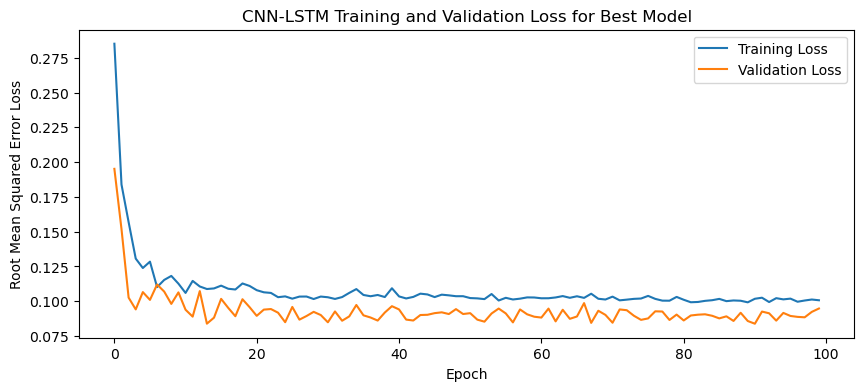

1/1 - 10s - loss: 0.0952 - 10s/epoch - 10s/step
Test Loss: 0.09517846256494522
Fold 2:
Epoch 1/100
19/19 [==============================] - 16s 381ms/step - loss: 0.2729 - val_loss: 0.2098
Epoch 2/100
19/19 [==============================] - 4s 192ms/step - loss: 0.1922 - val_loss: 0.1299
Epoch 3/100
19/19 [==============================] - 3s 165ms/step - loss: 0.1655 - val_loss: 0.1358
Epoch 4/100
19/19 [==============================] - 4s 202ms/step - loss: 0.1497 - val_loss: 0.1014
Epoch 5/100
19/19 [==============================] - 4s 193ms/step - loss: 0.1305 - val_loss: 0.1147
Epoch 6/100
19/19 [==============================] - 4s 198ms/step - loss: 0.1186 - val_loss: 0.0804
Epoch 7/100
19/19 [==============================] - 4s 222ms/step - loss: 0.1038 - val_loss: 0.0947
Epoch 8/100
19/19 [==============================] - 4s 216ms/step - loss: 0.1043 - val_loss: 0.0967
Epoch 9/100
19/19 [==============================] - 4s 192ms/step - loss: 0.1056 - val_loss: 0.0739
Epo

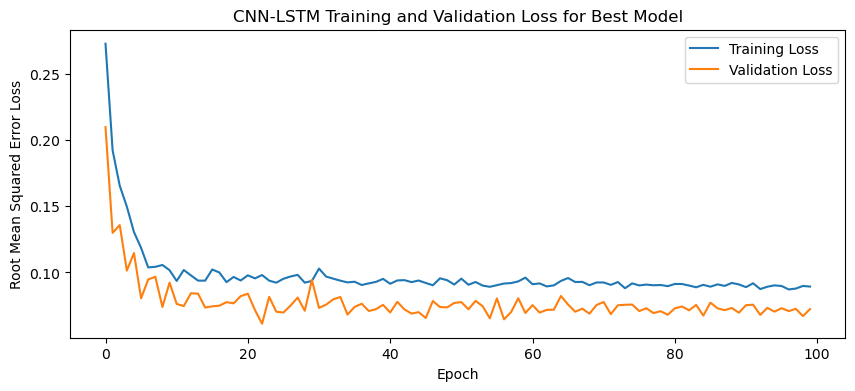

1/1 - 5s - loss: 0.0901 - 5s/epoch - 5s/step
Test Loss: 0.09014976024627686
Fold 3:
Epoch 1/100
19/19 [==============================] - 25s 381ms/step - loss: 0.2705 - val_loss: 0.1571
Epoch 2/100
19/19 [==============================] - 2s 122ms/step - loss: 0.2037 - val_loss: 0.1324
Epoch 3/100
19/19 [==============================] - 2s 131ms/step - loss: 0.1778 - val_loss: 0.1448
Epoch 4/100
19/19 [==============================] - 2s 128ms/step - loss: 0.1462 - val_loss: 0.0865
Epoch 5/100
19/19 [==============================] - 3s 160ms/step - loss: 0.1254 - val_loss: 0.0879
Epoch 6/100
19/19 [==============================] - 3s 137ms/step - loss: 0.1101 - val_loss: 0.0887
Epoch 7/100
19/19 [==============================] - 3s 134ms/step - loss: 0.1121 - val_loss: 0.0913
Epoch 8/100
19/19 [==============================] - 3s 175ms/step - loss: 0.1067 - val_loss: 0.0591
Epoch 9/100
19/19 [==============================] - 3s 163ms/step - loss: 0.1028 - val_loss: 0.0682
Epoch 

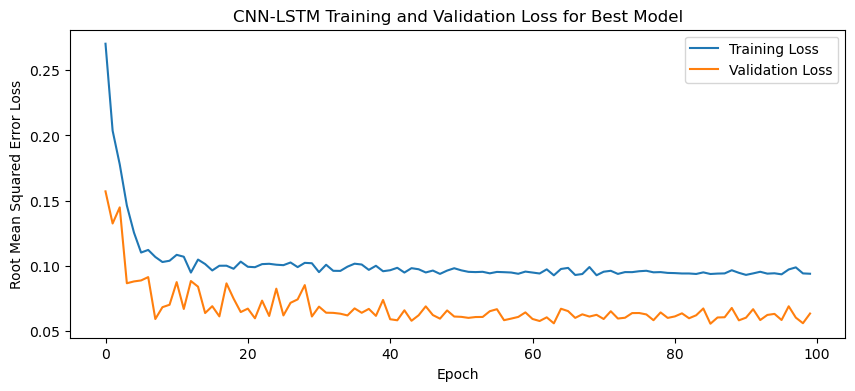

1/1 - 7s - loss: 0.0756 - 7s/epoch - 7s/step
Test Loss: 0.07562969624996185
Fold 4:
Epoch 1/100
20/20 [==============================] - 30s 450ms/step - loss: 0.3260 - val_loss: 0.1668
Epoch 2/100
20/20 [==============================] - 3s 169ms/step - loss: 0.2086 - val_loss: 0.1722
Epoch 3/100
20/20 [==============================] - 4s 178ms/step - loss: 0.1607 - val_loss: 0.2106
Epoch 4/100
20/20 [==============================] - 3s 169ms/step - loss: 0.1576 - val_loss: 0.1340
Epoch 5/100
20/20 [==============================] - 4s 201ms/step - loss: 0.1430 - val_loss: 0.2107
Epoch 6/100
20/20 [==============================] - 3s 161ms/step - loss: 0.1177 - val_loss: 0.1427
Epoch 7/100
20/20 [==============================] - 4s 184ms/step - loss: 0.1098 - val_loss: 0.1575
Epoch 8/100
20/20 [==============================] - 4s 202ms/step - loss: 0.1096 - val_loss: 0.1248
Epoch 9/100
20/20 [==============================] - 4s 203ms/step - loss: 0.1056 - val_loss: 0.1460
Epoch 

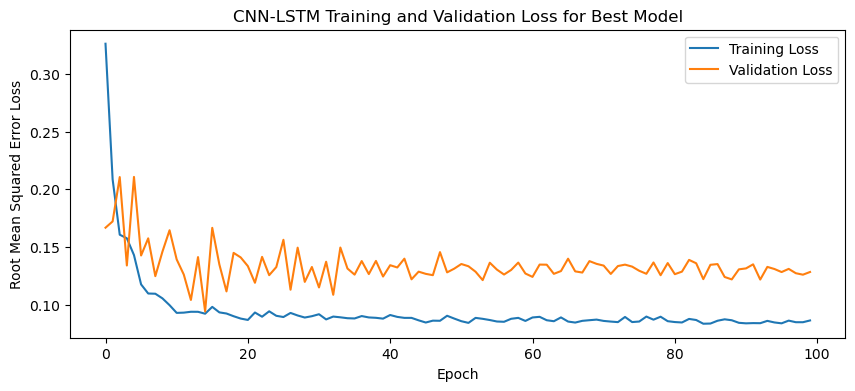

1/1 - 6s - loss: 0.1048 - 6s/epoch - 6s/step
Test Loss: 0.10477161407470703
Fold 5:
Epoch 1/100
19/19 [==============================] - 27s 398ms/step - loss: 0.3014 - val_loss: 0.1616
Epoch 2/100
19/19 [==============================] - 4s 220ms/step - loss: 0.1987 - val_loss: 0.1915
Epoch 3/100
19/19 [==============================] - 3s 178ms/step - loss: 0.1696 - val_loss: 0.2159
Epoch 4/100
19/19 [==============================] - 3s 150ms/step - loss: 0.1482 - val_loss: 0.1647
Epoch 5/100
19/19 [==============================] - 3s 178ms/step - loss: 0.1375 - val_loss: 0.1221
Epoch 6/100
19/19 [==============================] - 3s 166ms/step - loss: 0.1044 - val_loss: 0.1306
Epoch 7/100
19/19 [==============================] - 3s 175ms/step - loss: 0.0990 - val_loss: 0.1446
Epoch 8/100
19/19 [==============================] - 4s 197ms/step - loss: 0.0953 - val_loss: 0.1626
Epoch 9/100
19/19 [==============================] - 3s 178ms/step - loss: 0.0962 - val_loss: 0.1289
Epoch 

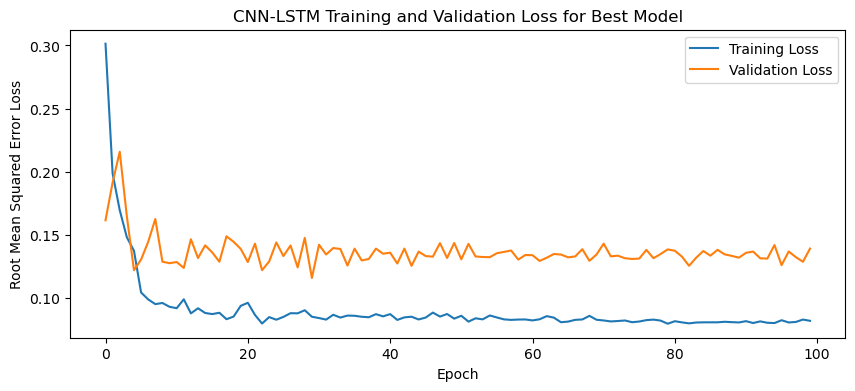

1/1 - 3s - loss: 0.0709 - 3s/epoch - 3s/step
Test Loss: 0.07088327407836914


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit a CNN-LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    filters = trial.suggest_categorical('filters', [256, 512, 1024]) # Used for CNN-LSTM model
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM Only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "CNN-LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

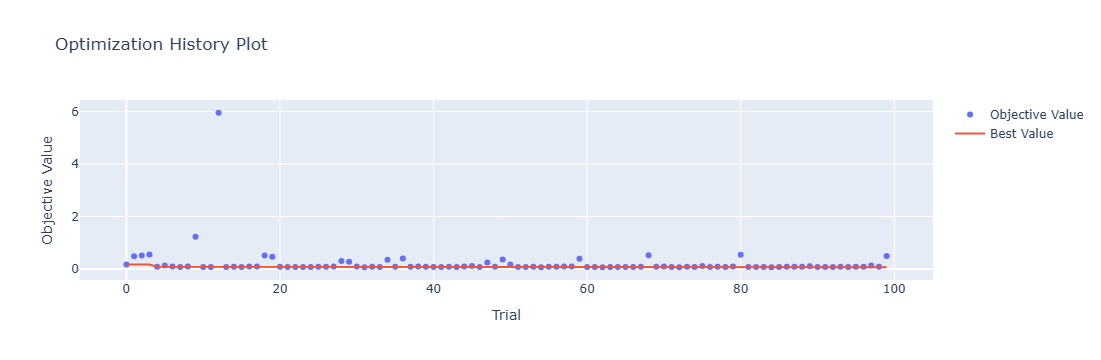

In [4]:
optuna.visualization.plot_optimization_history(study)

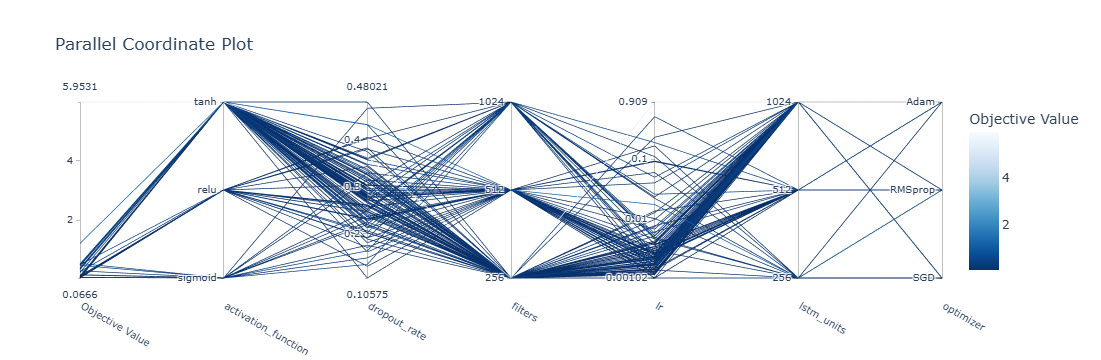

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

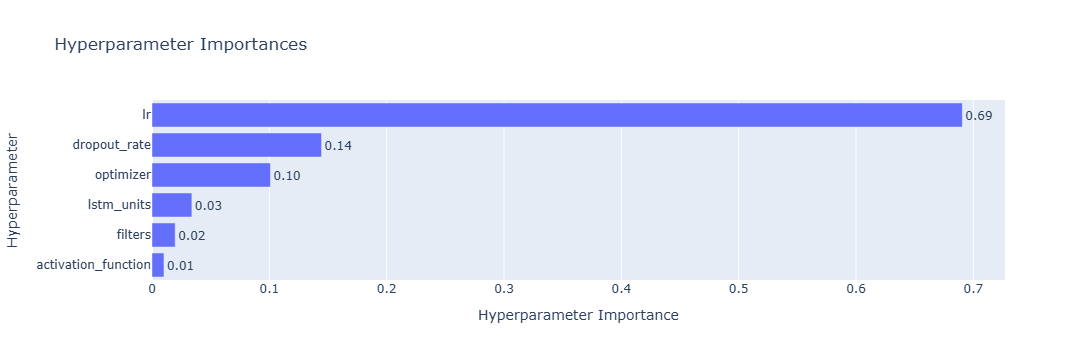

In [6]:
optuna.visualization.plot_param_importances(study)

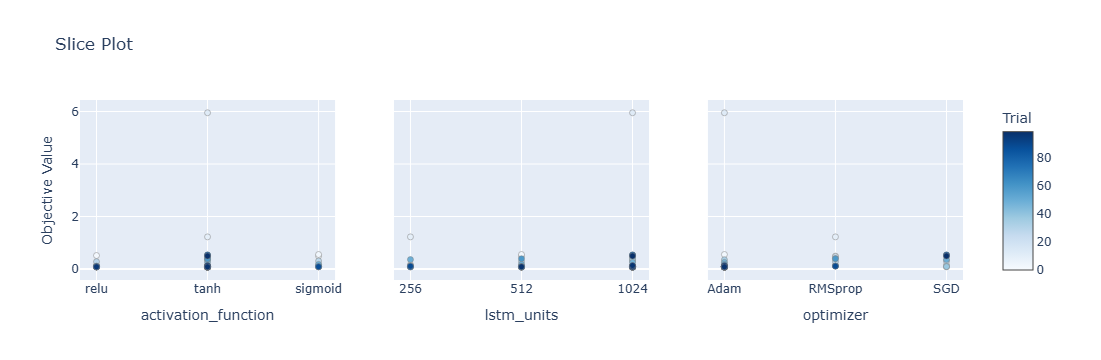

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

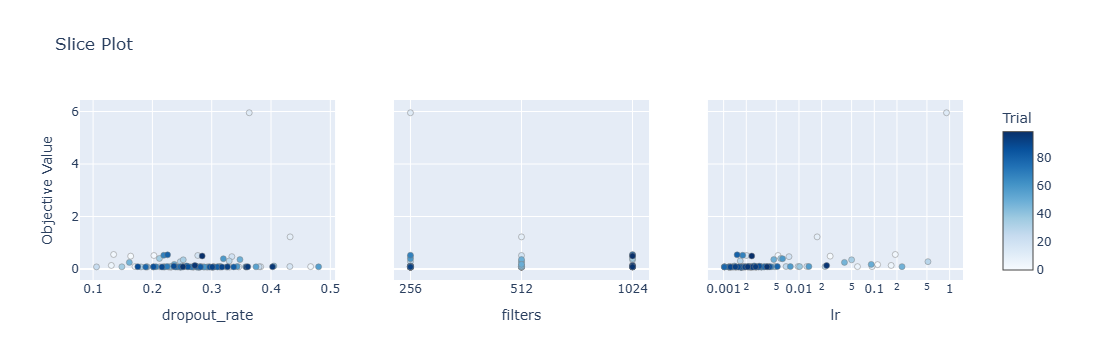

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate', 'filters'])

[[20.84 20.69 20.47 20.3  20.46 20.31 20.43 20.63 21.05 20.79 20.3  20.47
  19.79 21.11 21.38 20.92 20.47 21.77 22.5  22.86 21.64 21.57 21.74 21.57
  21.81 22.23 22.62]
 [16.57 15.99 15.39 15.45 15.98 15.45 15.57 15.59 15.96 16.16 15.83 15.88
  15.64 16.44 17.   15.83 15.63 16.9  17.06 17.3  17.26 18.21 17.38 16.87
  17.15 16.98 18.47]]
Epoch 1/100
19/19 [==============================] - 37s 528ms/step - loss: 0.2773 - accuracy: 0.1579 - mae: 0.2445 - rmse: 0.2773 - mape: 42.7885 - pearson: 0.2470 - val_loss: 0.2084 - val_accuracy: 0.3333 - val_mae: 0.1657 - val_rmse: 0.2084 - val_mape: 30.2853 - val_pearson: 0.3425
Epoch 2/100
19/19 [==============================] - 3s 157ms/step - loss: 0.2121 - accuracy: 0.3684 - mae: 0.1732 - rmse: 0.2121 - mape: 30.0674 - pearson: 0.2585 - val_loss: 0.1449 - val_accuracy: 0.3333 - val_mae: 0.1176 - val_rmse: 0.1449 - val_mape: 21.3577 - val_pearson: 0.5333
Epoch 3/100
19/19 [==============================] - 3s 165ms/step - loss: 0.1570 - accura

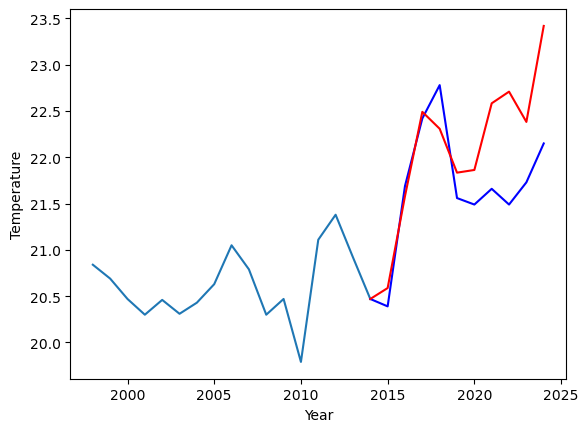

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
16.37		16.32		-0.05
17.64		17.31		-0.33
17.80		18.22		0.42
18.04		18.04		-0.00
18.00		17.56		-0.44
18.95		17.59		-1.36
18.12		18.31		0.19
17.61		18.44		0.83
17.89		18.11		0.22
17.72		19.15		1.43


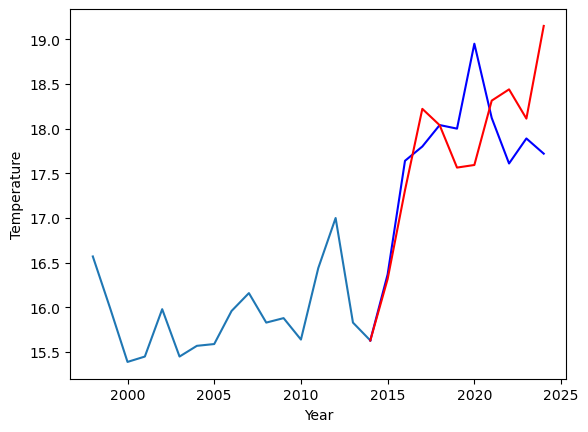

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   20.39  20.588134
1                1   16.37  16.318052


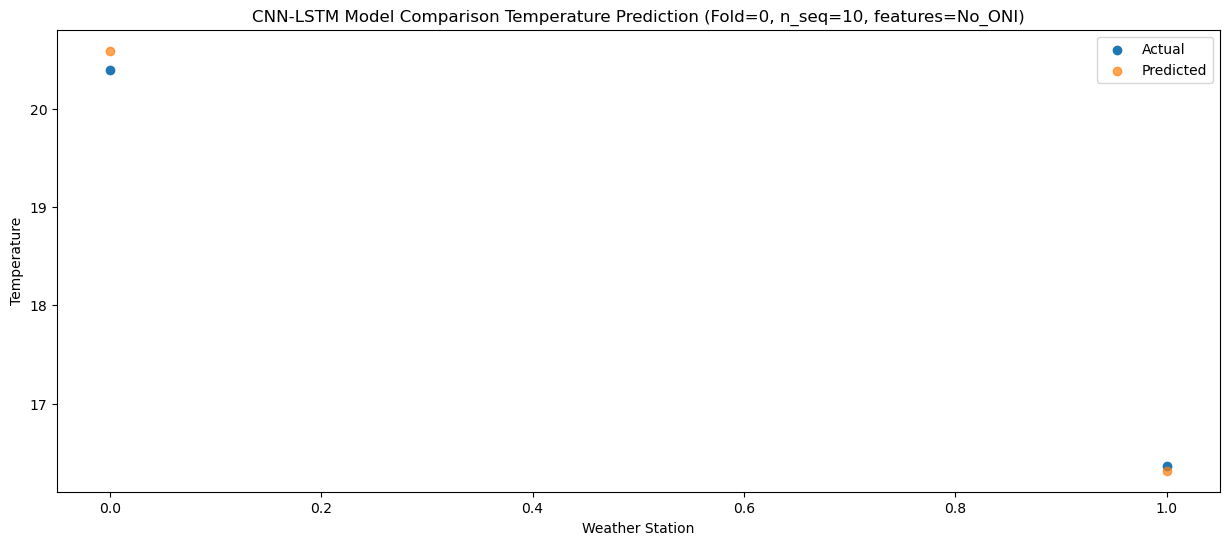

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   21.69  21.580931
1                1   17.64  17.310813


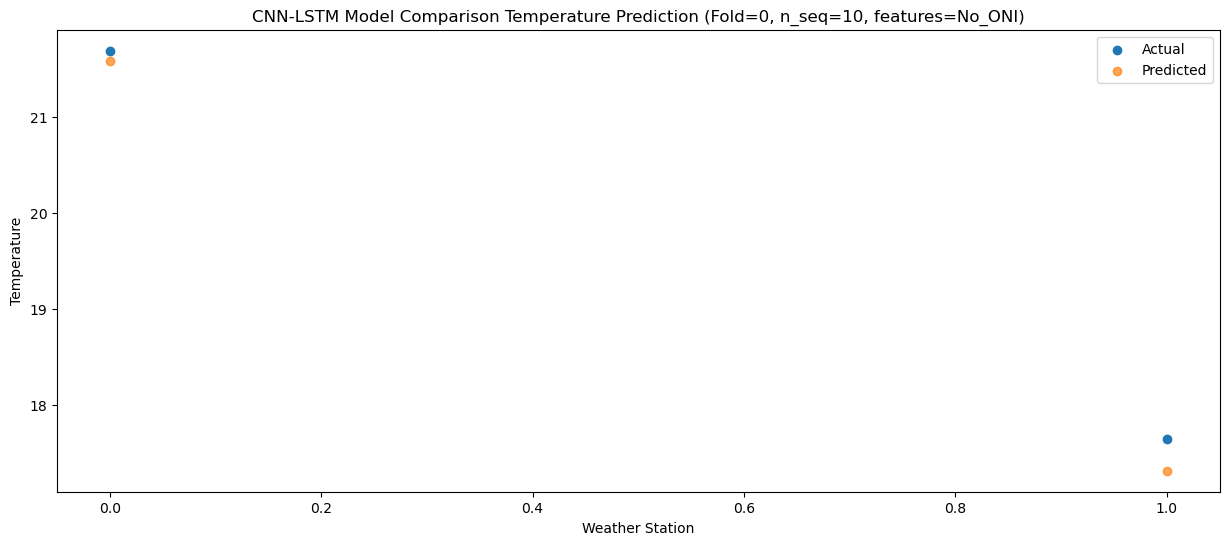

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   22.42  22.491409
1                1   17.80  18.221213


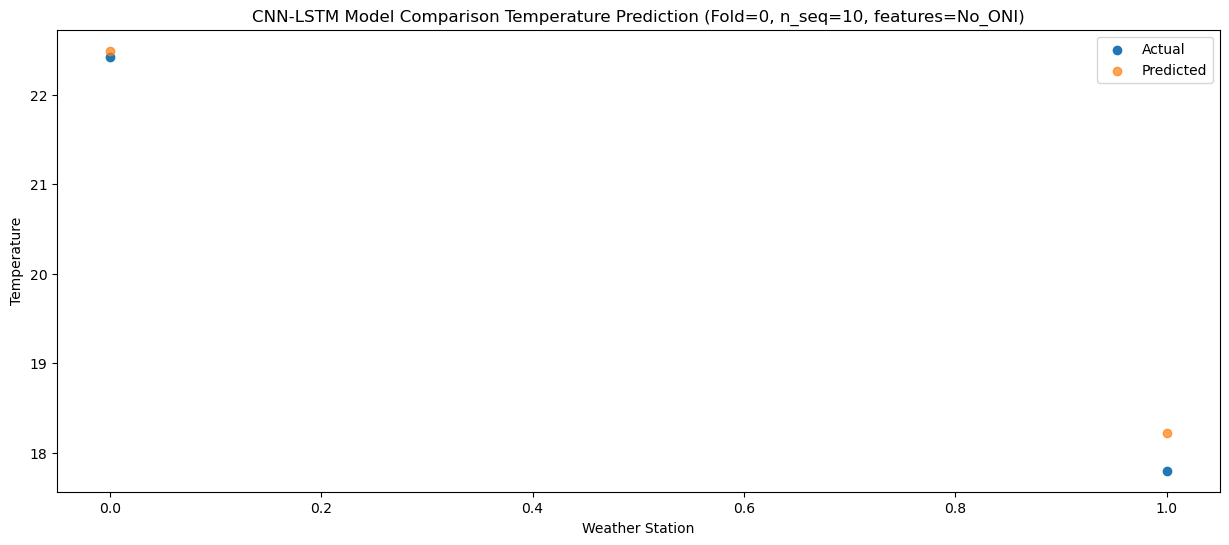

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   22.78  22.308486
1                1   18.04  18.038284


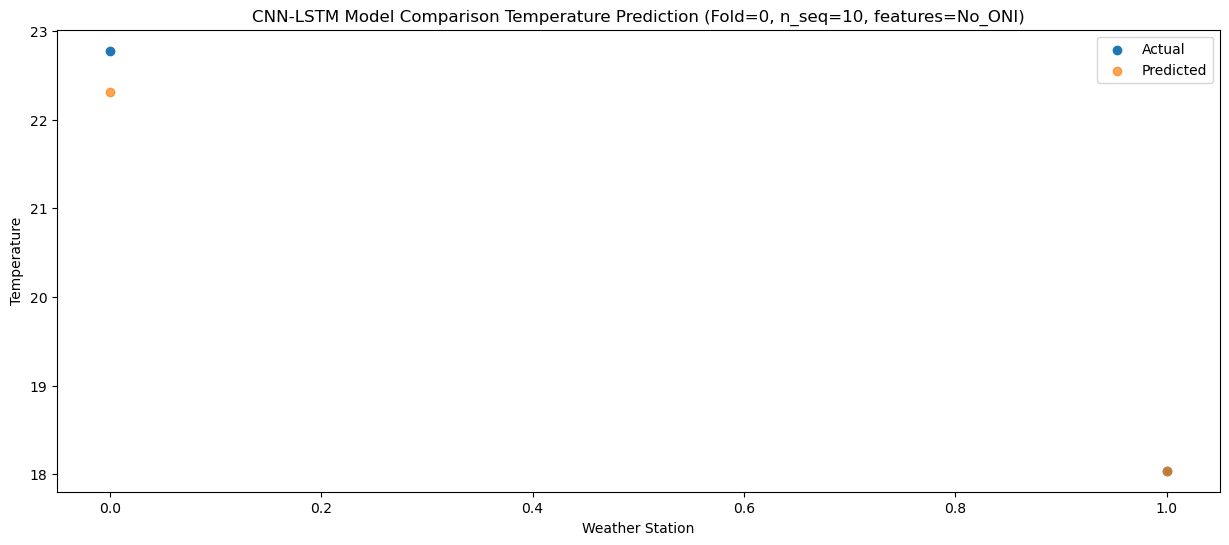

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.56  21.834487
1                1   18.00  17.564239


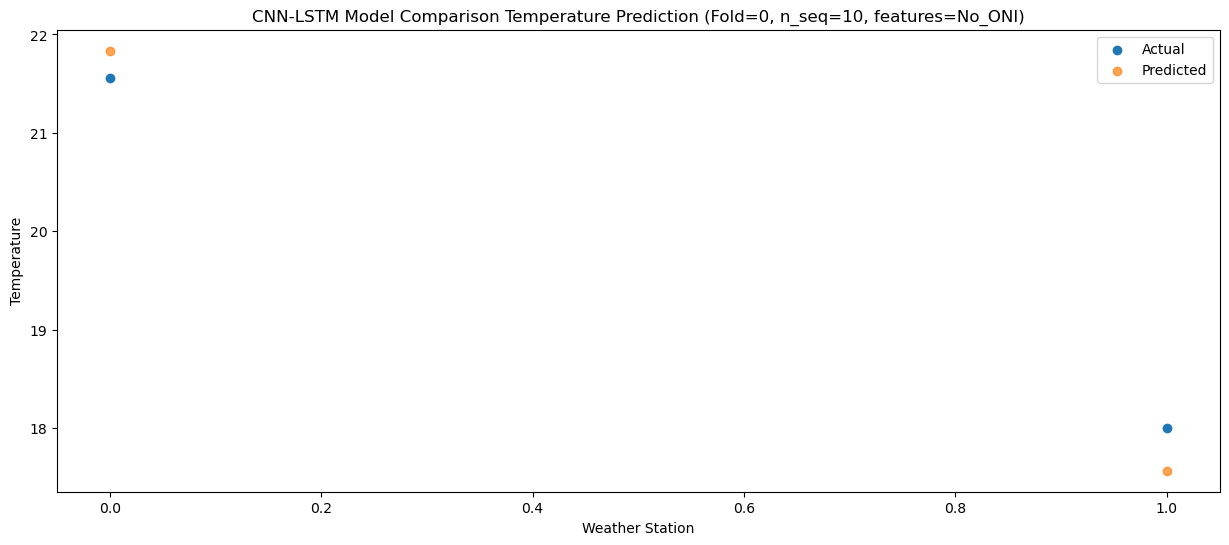

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   21.49  21.863574
1                1   18.95  17.593286


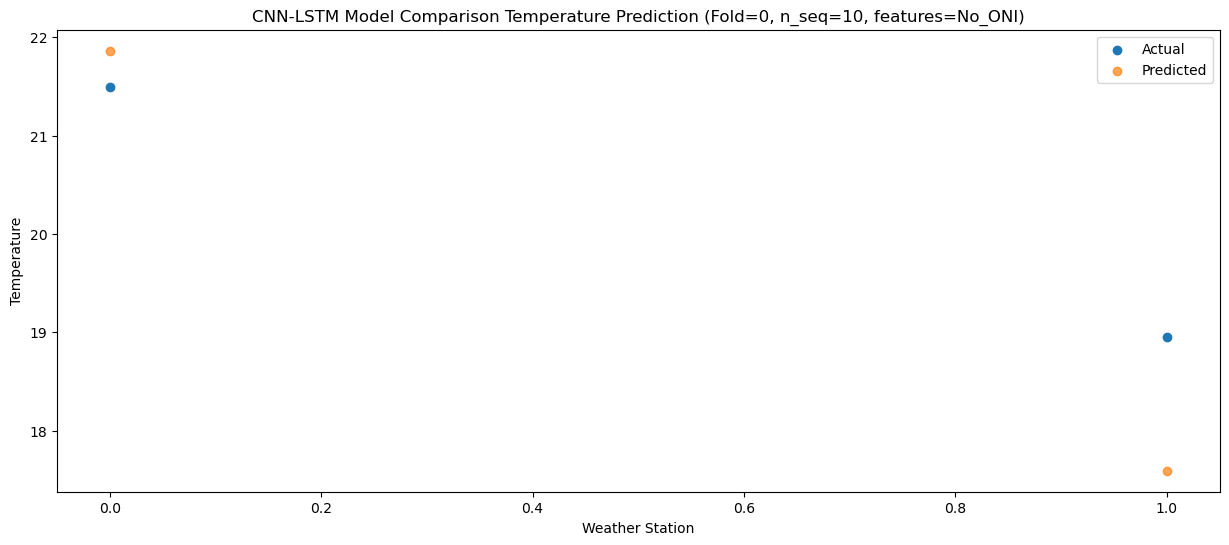

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   21.66  22.583583
1                1   18.12  18.313211


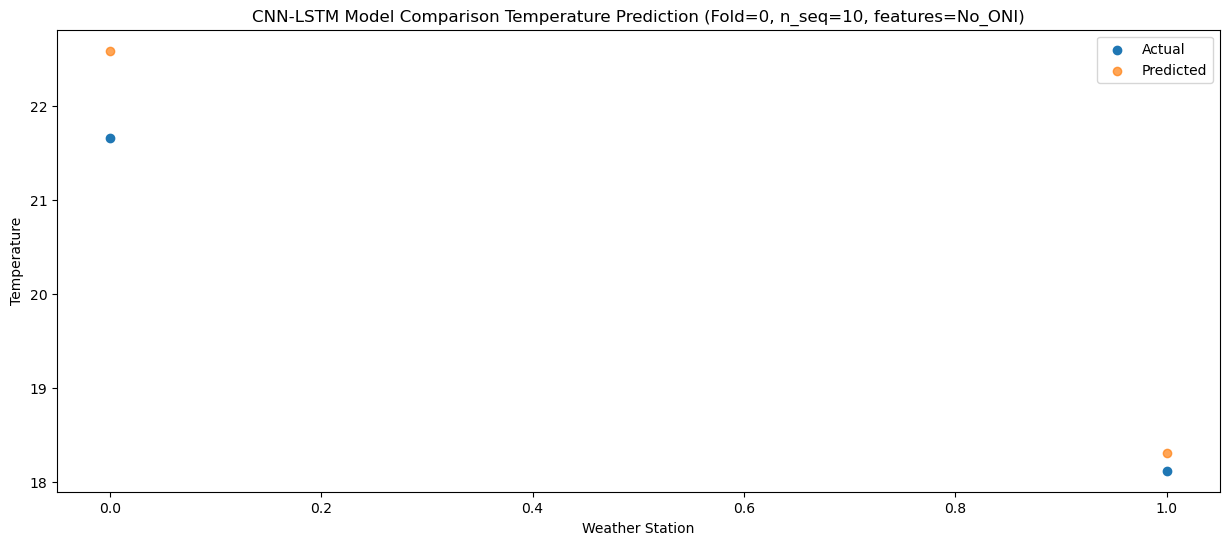

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   21.49  22.709520
1                1   17.61  18.439162


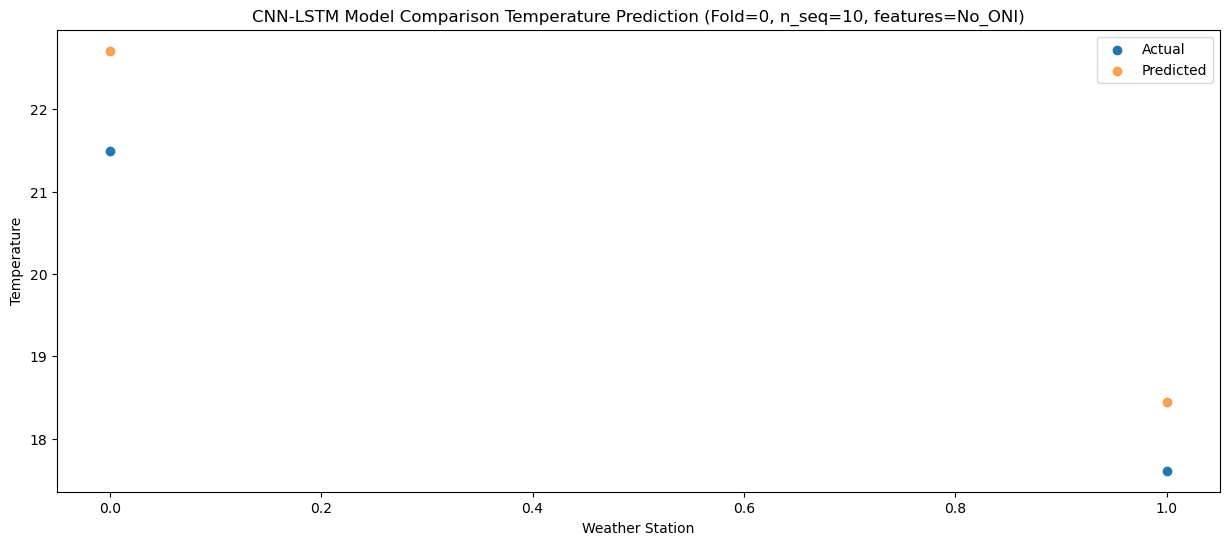

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   21.73  22.382563
1                1   17.89  18.112202


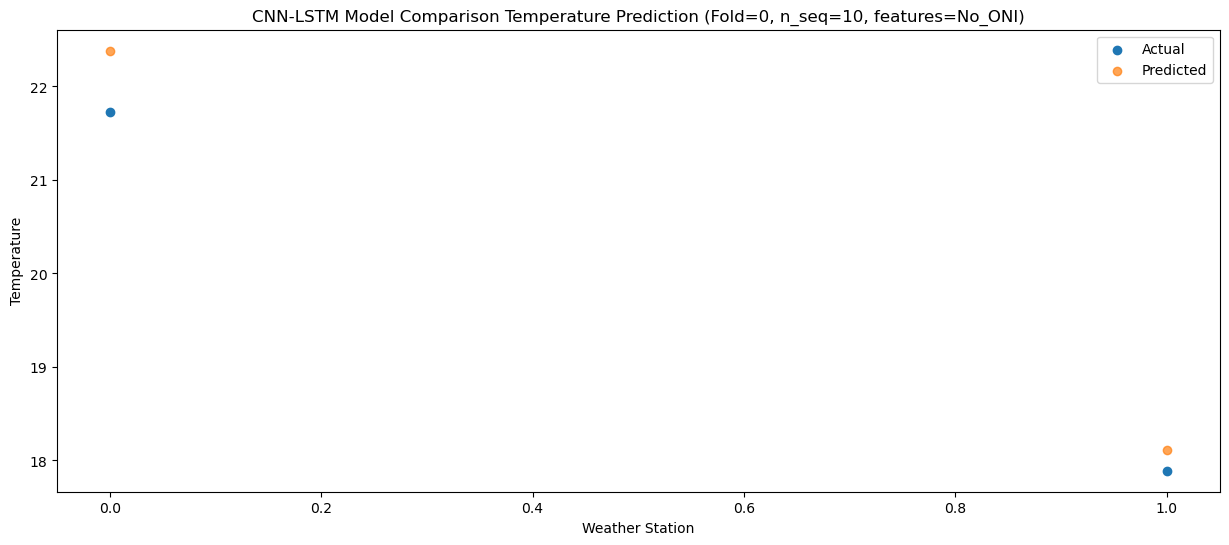

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   22.15  23.419485
1                1   17.72  19.149081


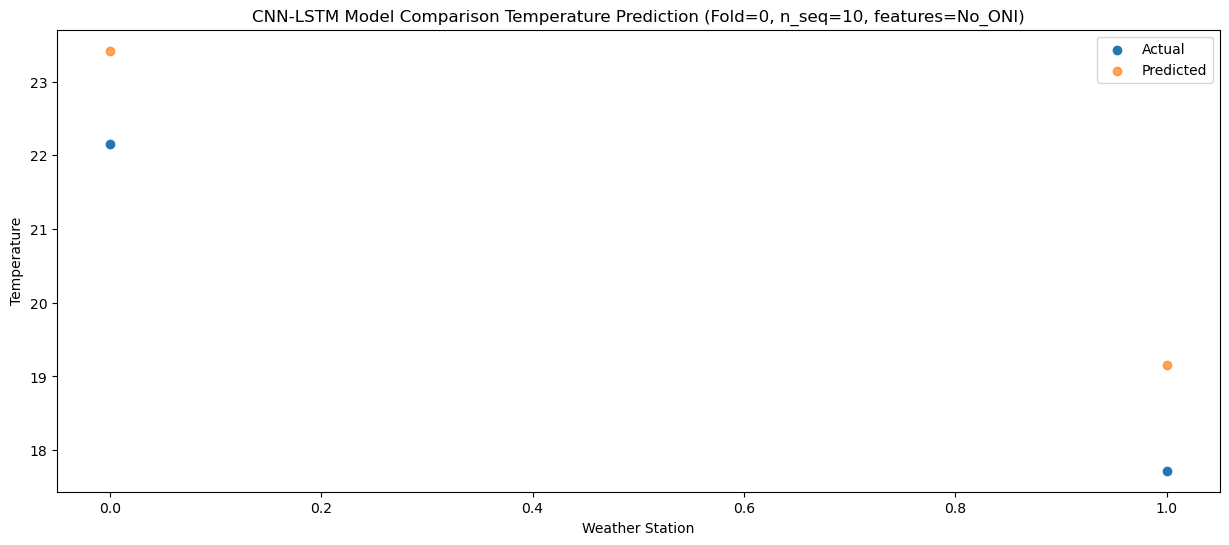

f, t:
[[20.39 16.37]
 [21.69 17.64]
 [22.42 17.8 ]
 [22.78 18.04]
 [21.56 18.  ]
 [21.49 18.95]
 [21.66 18.12]
 [21.49 17.61]
 [21.73 17.89]
 [22.15 17.72]]
[[20.58813414 16.31805242]
 [21.58093086 17.31081337]
 [22.49140903 18.22121275]
 [22.30848558 18.03828383]
 [21.83448724 17.56423918]
 [21.86357381 17.59328562]
 [22.5835826  18.31321127]
 [22.70952019 18.43916199]
 [22.38256282 18.11220169]
 [23.41948516 19.149081  ]]
Year at t+1:
t+1 SKRMSE: 0.144837
t+1 KRMSE: 0.144837
t+1 MAE: 0.125041
t+1 SKMAPE: 0.006445
t+1 R2_SCORE: 0.994808
t+1 KMAPE: 0.006445
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.245214
t+2 KRMSE: 0.245214
t+2 MAE: 0.219128
t+2 SKMAPE: 0.011845
t+2 R2_SCORE: 0.985336
t+2 KMAPE: 0.011845
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.302092
t+3 KRMSE: 0.302092
t+3 MAE: 0.246311
t+3 SKMAPE: 0.013424
t+3 R2_SCORE: 0.982898
t+3 KMAPE: 0.013424
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.333413
t+4 KRMSE: 0.333413
t+4 MAE: 0.236615
t+4 SKMAPE: 0.010397
t+4 R

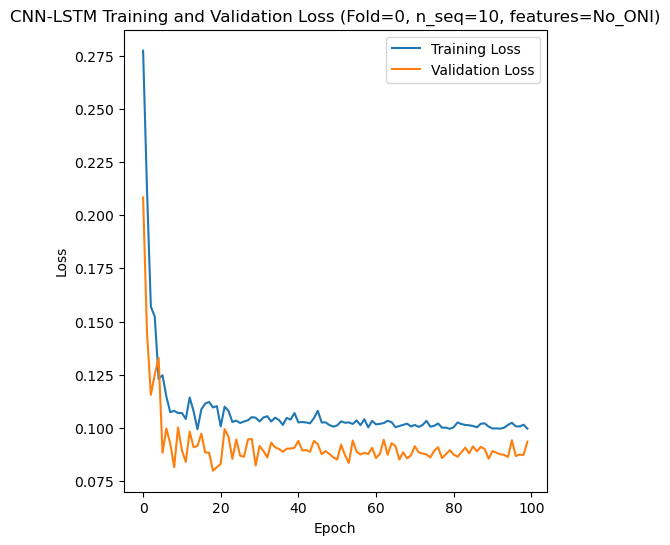

[[19.54 18.69 17.98 18.61 18.9  18.32 18.53 18.52 18.91 19.16 18.59 18.48
  18.2  19.26 19.25 18.86 18.95 19.48 19.77 19.73 19.56 19.64 19.73 18.81
  19.15 19.99 20.79]
 [19.69 19.59 19.68 19.6  19.14 19.33 18.41 19.15 20.48 18.58 19.32 19.44
  18.75 20.43 20.08 18.77 18.96 18.48 19.51 19.89 19.04 19.17 19.69 19.3
  19.3  20.61 21.9 ]]
Epoch 1/100
19/19 [==============================] - 44s 772ms/step - loss: 0.2416 - accuracy: 0.1579 - mae: 0.2125 - rmse: 0.2416 - mape: 34.4250 - pearson: 0.2551 - val_loss: 0.1639 - val_accuracy: 0.0000e+00 - val_mae: 0.1425 - val_rmse: 0.1639 - val_mape: 24.0841 - val_pearson: 0.3882
Epoch 2/100
19/19 [==============================] - 3s 142ms/step - loss: 0.1723 - accuracy: 0.4211 - mae: 0.1450 - rmse: 0.1723 - mape: 22.9585 - pearson: 0.3196 - val_loss: 0.0897 - val_accuracy: 1.0000 - val_mae: 0.0729 - val_rmse: 0.0897 - val_mape: 12.7791 - val_pearson: 0.5342
Epoch 3/100
19/19 [==============================] - 3s 147ms/step - loss: 0.1858 - acc

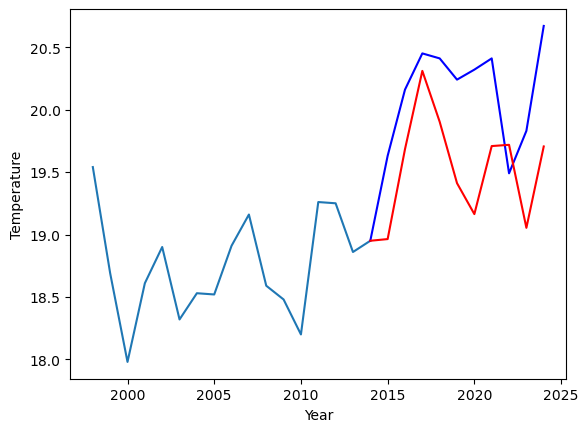

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
19.88		19.11		-0.77
19.40		19.83		0.43
20.43		20.46		0.03
20.81		20.05		-0.76
19.96		19.56		-0.40
20.09		19.31		-0.78
20.61		19.86		-0.75
20.22		19.87		-0.35
20.22		19.20		-1.02
21.53		19.86		-1.67


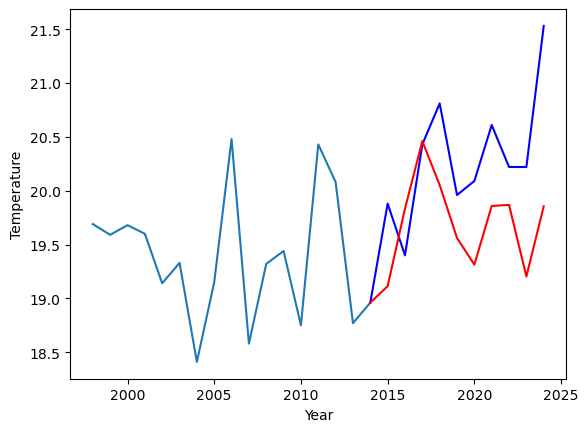

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   19.63  18.963484
1                1   19.88  19.113484


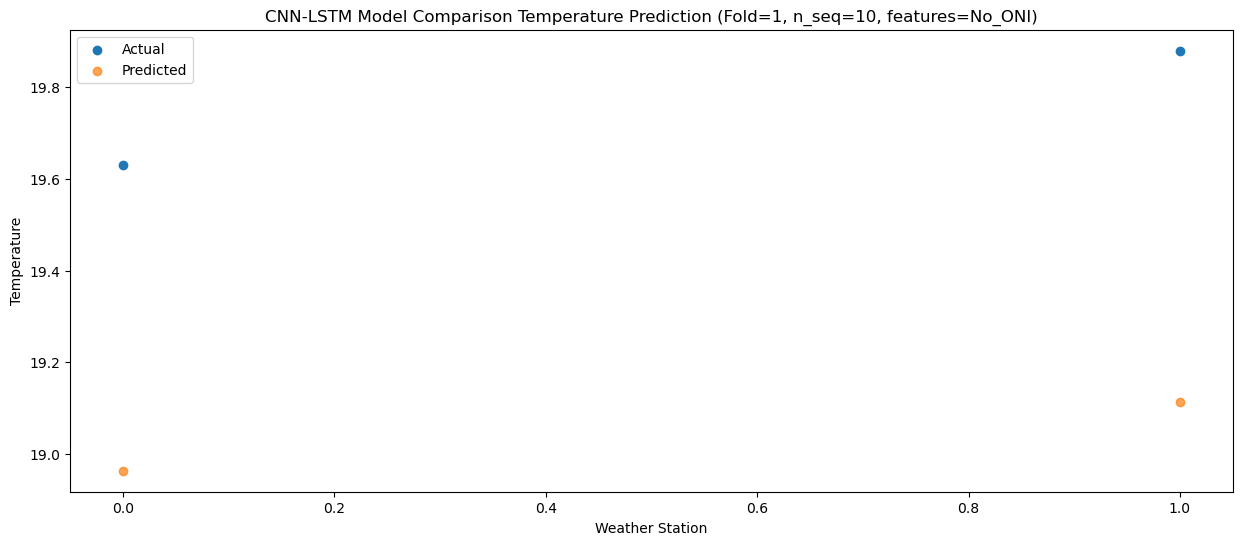

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   20.16  19.683398
1                1   19.40  19.833398


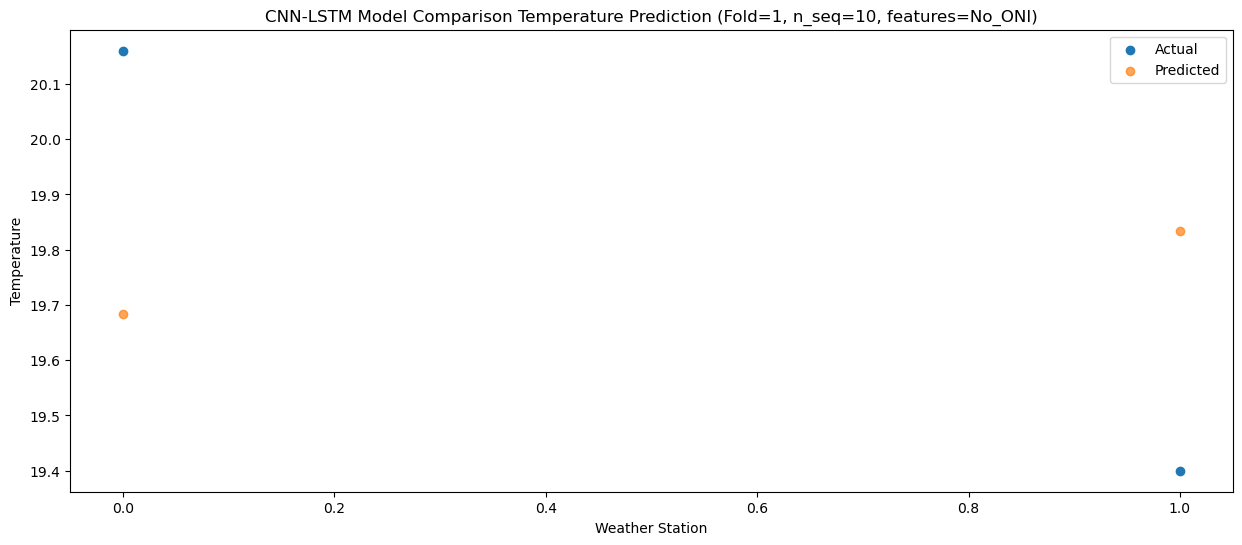

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   20.45  20.309999
1                1   20.43  20.459999


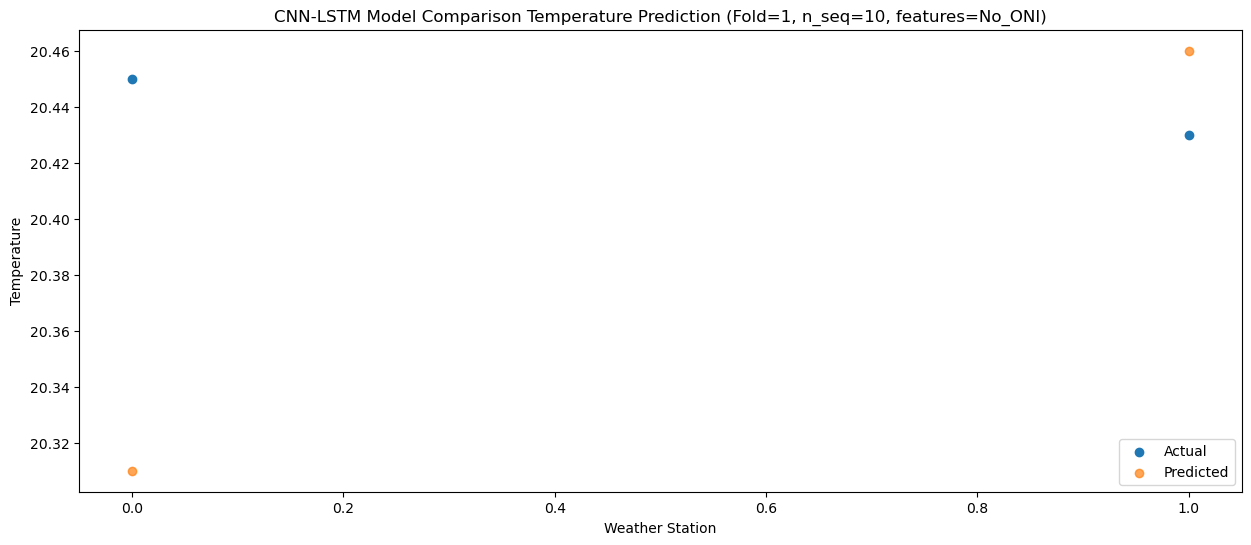

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   20.41   19.90275
1                1   20.81   20.05275


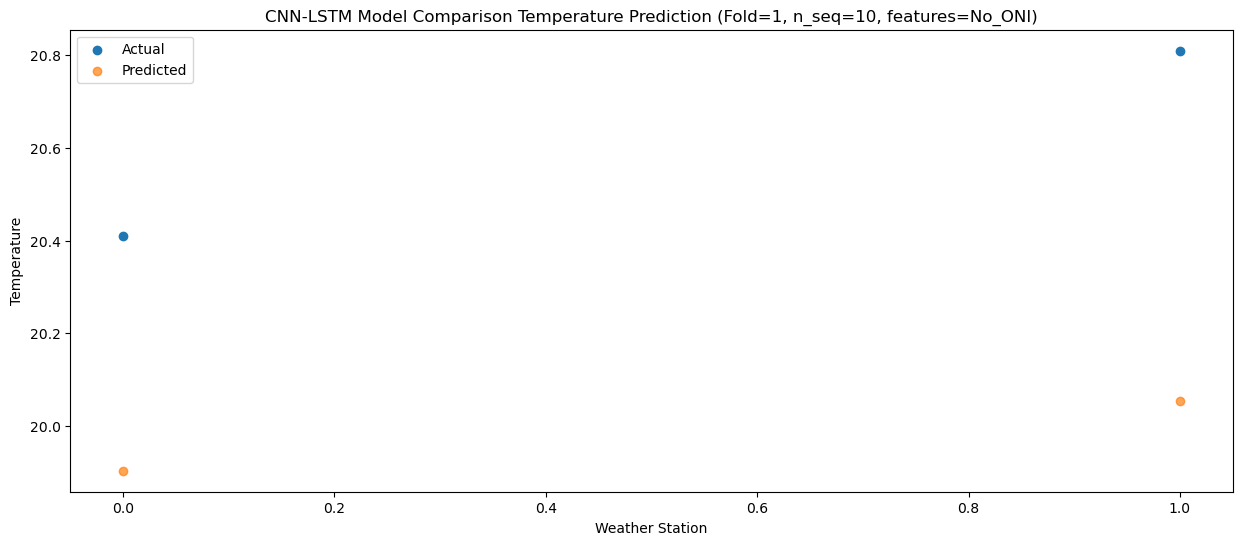

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   20.24  19.410952
1                1   19.96  19.560952


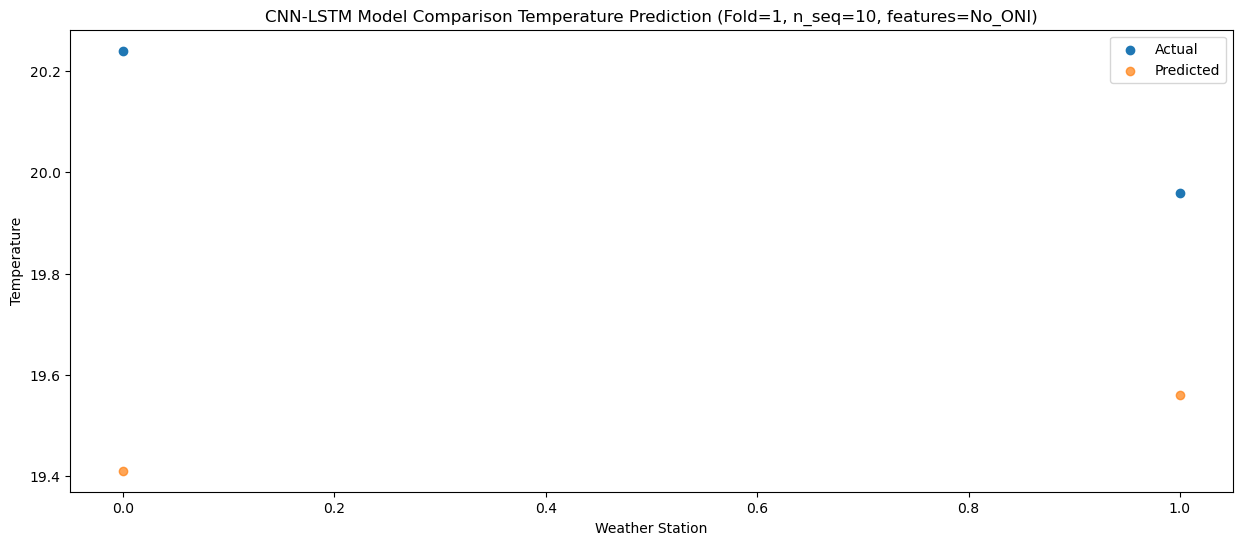

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   20.32  19.163432
1                1   20.09  19.313432


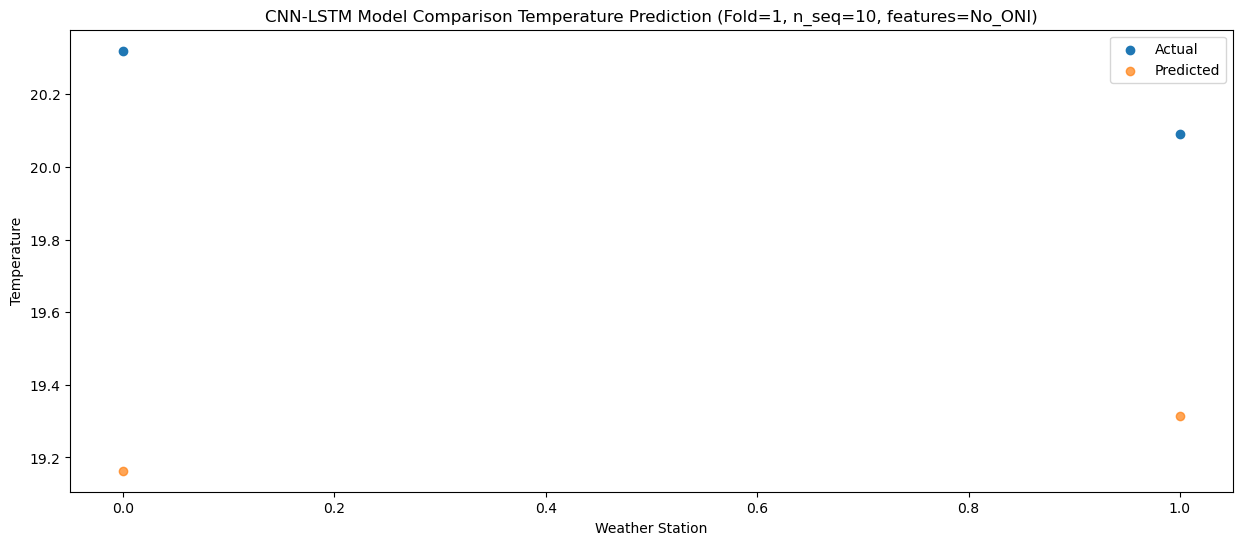

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   20.41  19.708117
1                1   20.61  19.858117


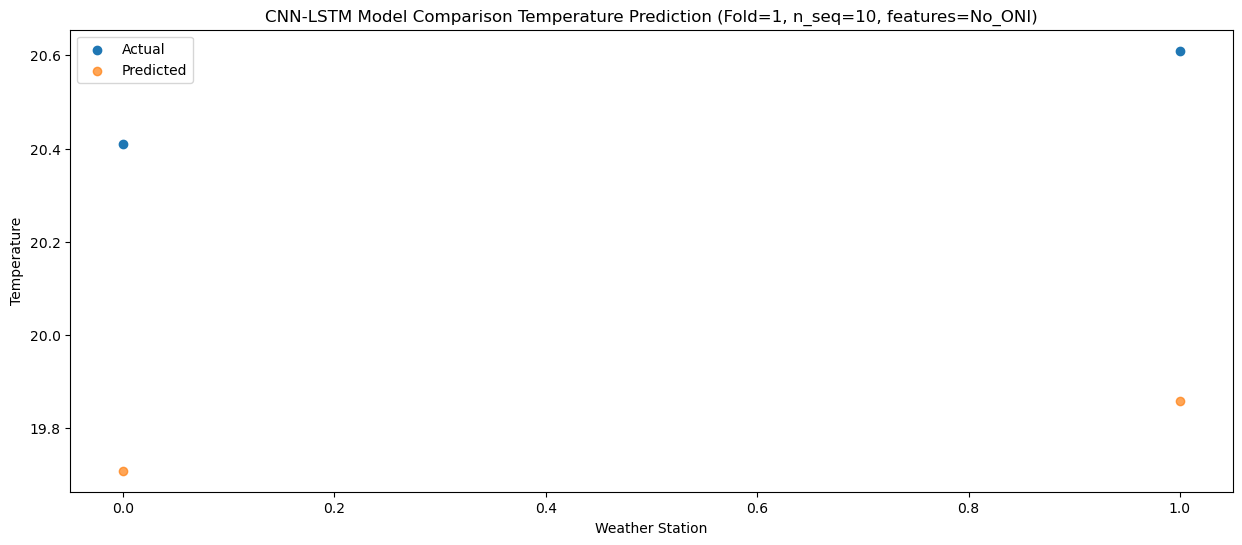

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   19.49  19.718075
1                1   20.22  19.868075


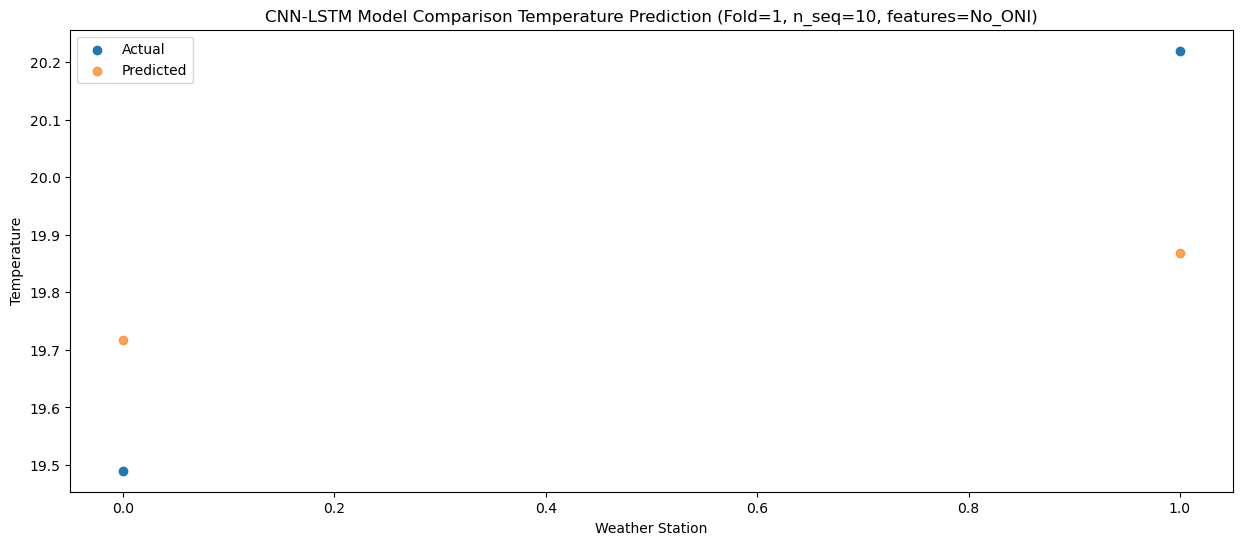

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   19.83  19.053503
1                1   20.22  19.203503


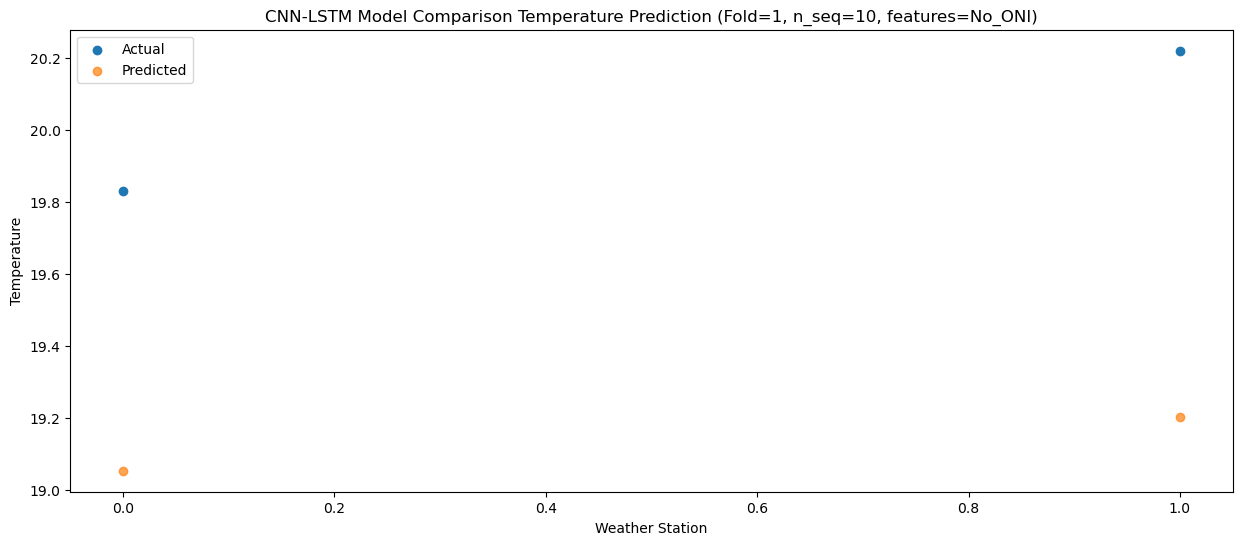

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   20.67  19.705018
1                1   21.53  19.855018


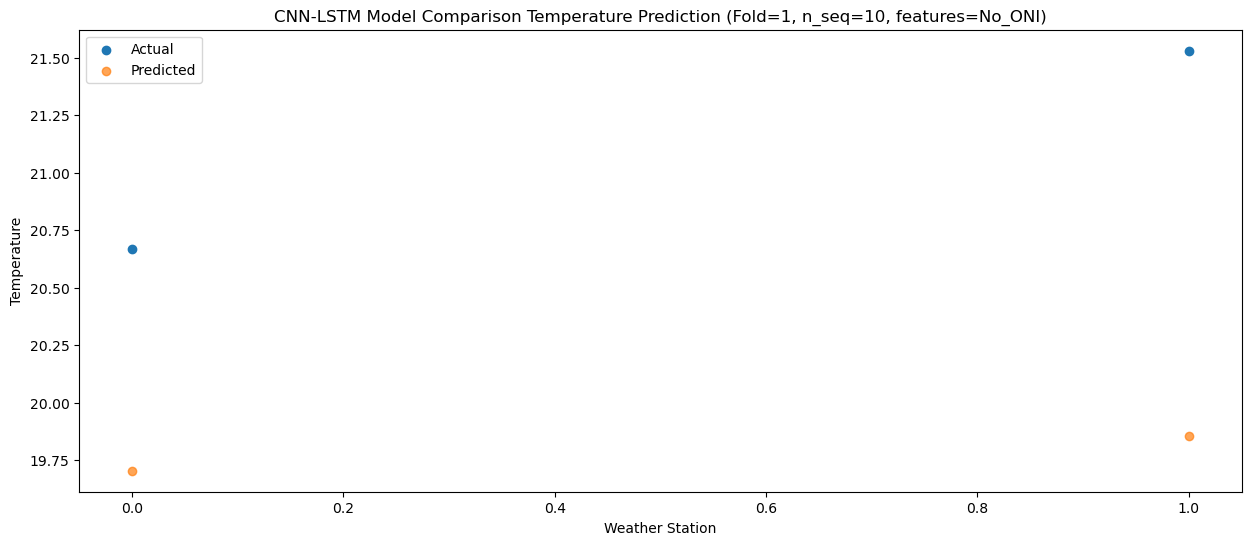

f, t:
[[19.63 19.88]
 [20.16 19.4 ]
 [20.45 20.43]
 [20.41 20.81]
 [20.24 19.96]
 [20.32 20.09]
 [20.41 20.61]
 [19.49 20.22]
 [19.83 20.22]
 [20.67 21.53]]
[[18.96348379 19.11348379]
 [19.68339769 19.83339769]
 [20.30999933 20.45999933]
 [19.90275017 20.05275017]
 [19.41095207 19.56095207]
 [19.1634317  19.3134317 ]
 [19.70811664 19.85811664]
 [19.71807476 19.86807476]
 [19.05350282 19.20350282]
 [19.70501794 19.85501794]]
Year at t+1:
t+1 SKRMSE: 0.718259
t+1 KRMSE: 0.718259
t+1 MAE: 0.716516
t+1 SKMAPE: 0.036256
t+1 R2_SCORE: -32.017311
t+1 KMAPE: 0.036256
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.455513
t+2 KRMSE: 0.455513
t+2 MAE: 0.455000
t+2 SKMAPE: 0.022991
t+2 R2_SCORE: -0.436923
t+2 KMAPE: 0.022991
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.101243
t+3 KRMSE: 0.101243
t+3 MAE: 0.085000
t+3 SKMAPE: 0.004157
t+3 R2_SCORE: -101.500742
t+3 KMAPE: 0.004157
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.644488
t+4 KRMSE: 0.644488
t+4 MAE: 0.632250
t+4 SKMAPE: 0.030621

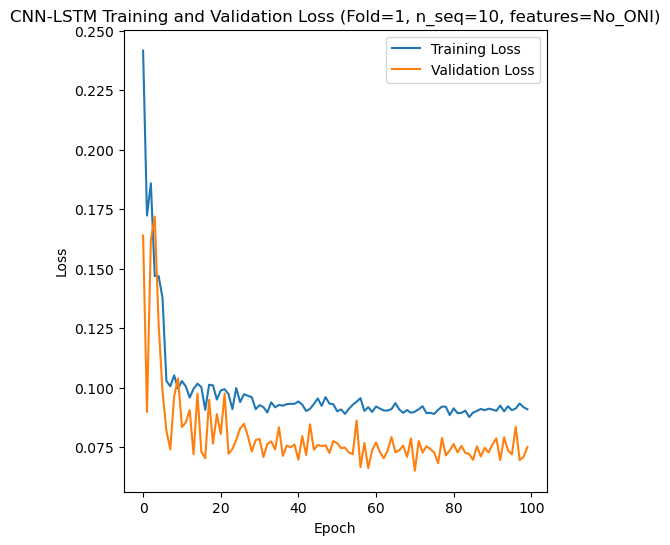

[[16.84 16.42 15.63 15.84 16.01 15.21 15.86 15.86 16.6  17.15 15.61 15.43
  15.69 16.61 16.97 15.29 15.43 16.62 17.18 16.96 16.33 17.09 16.39 16.63
  16.6  17.04 18.25]
 [13.51 12.74 11.83 12.67 12.83 11.71 12.25 12.85 13.05 13.49 12.15 12.07
  12.6  13.05 14.02 12.15 11.53 12.87 13.64 13.46 12.99 13.32 13.31 13.3
  12.84 13.63 15.32]]
Epoch 1/100
19/19 [==============================] - 40s 604ms/step - loss: 0.3263 - accuracy: 0.1053 - mae: 0.2879 - rmse: 0.3263 - mape: 45.7358 - pearson: 0.1272 - val_loss: 0.3260 - val_accuracy: 0.3333 - val_mae: 0.2929 - val_rmse: 0.3260 - val_mape: 46.0536 - val_pearson: 0.5516
Epoch 2/100
19/19 [==============================] - 2s 131ms/step - loss: 0.2009 - accuracy: 0.2632 - mae: 0.1708 - rmse: 0.2009 - mape: 27.8539 - pearson: 0.2783 - val_loss: 0.1901 - val_accuracy: 0.3333 - val_mae: 0.1767 - val_rmse: 0.1901 - val_mape: 27.9464 - val_pearson: 0.3234
Epoch 3/100
19/19 [==============================] - 2s 124ms/step - loss: 0.1792 - accurac

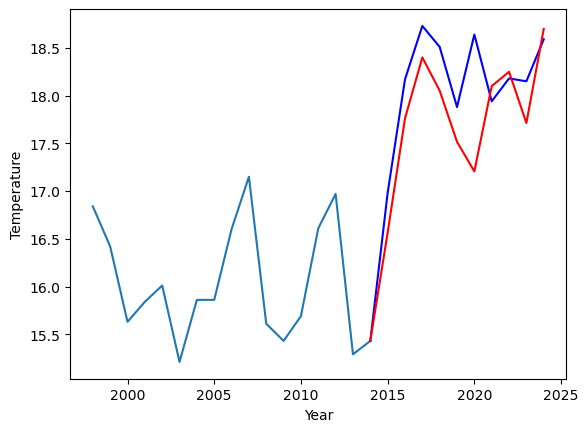

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.89		13.23		0.34
14.23		14.43		0.20
15.00		15.07		0.07
14.82		14.72		-0.10
14.35		14.19		-0.16
14.68		13.88		-0.80
14.67		14.77		0.10
14.66		14.92		0.26
14.20		14.38		0.18
14.99		15.37		0.38


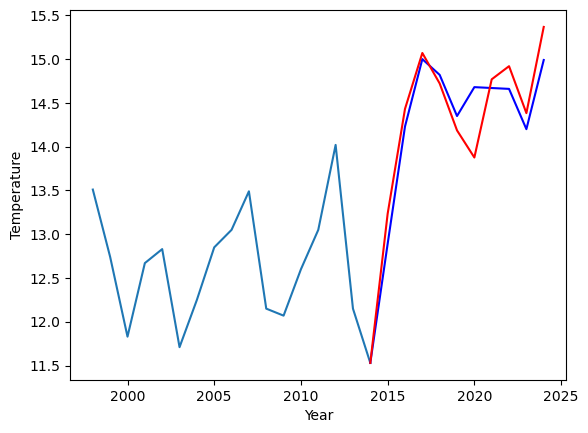

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   16.98  16.563475
1                1   12.89  13.233475


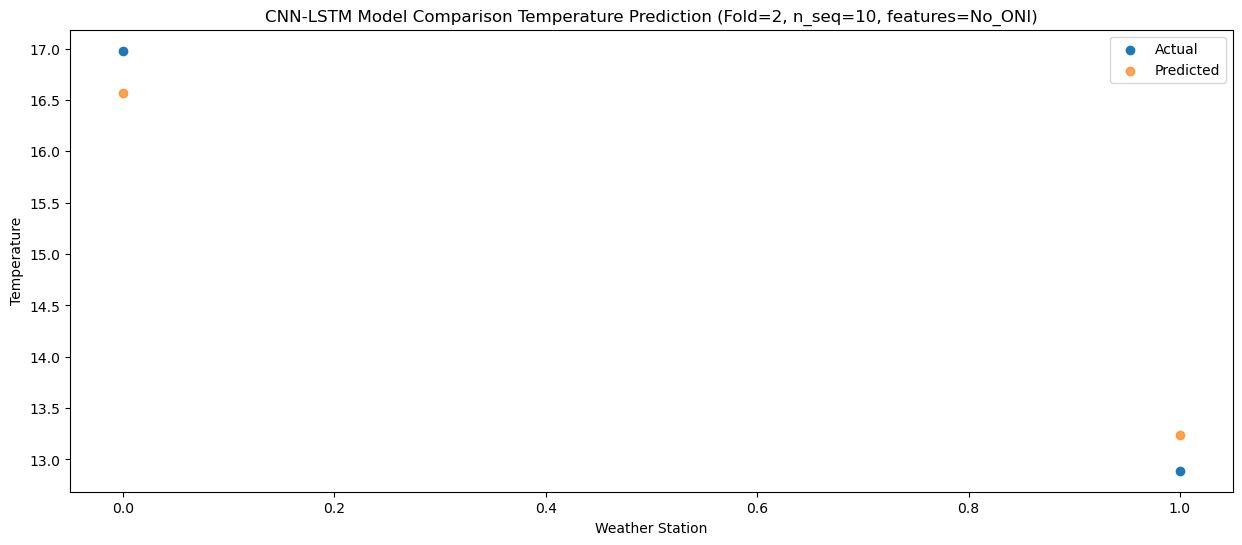

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   18.17  17.761303
1                1   14.23  14.431303


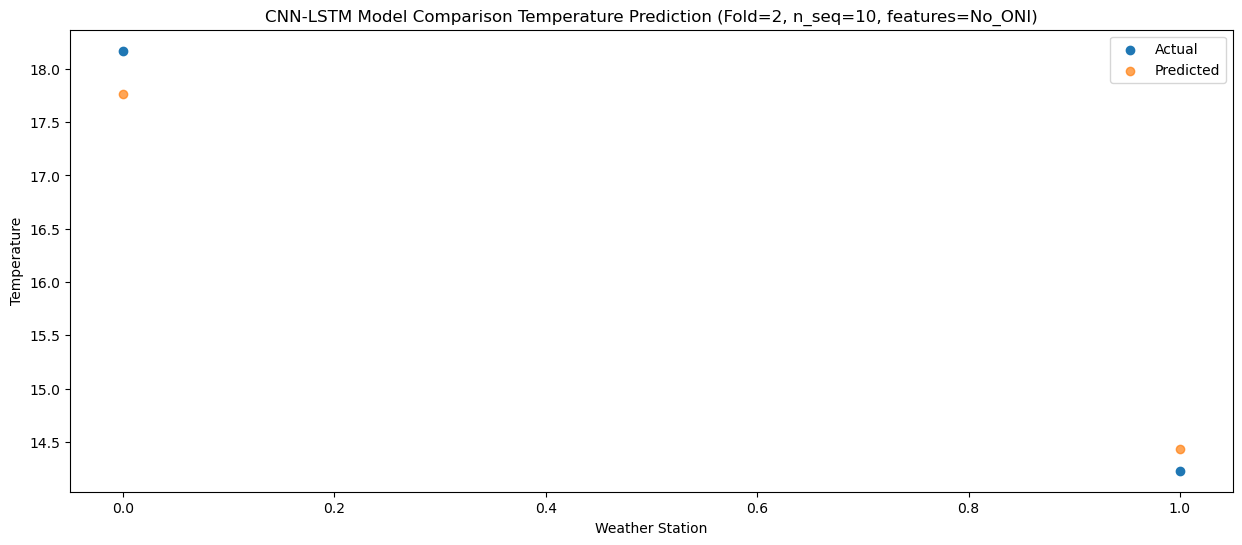

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   18.73   18.40007
1                1   15.00   15.07007


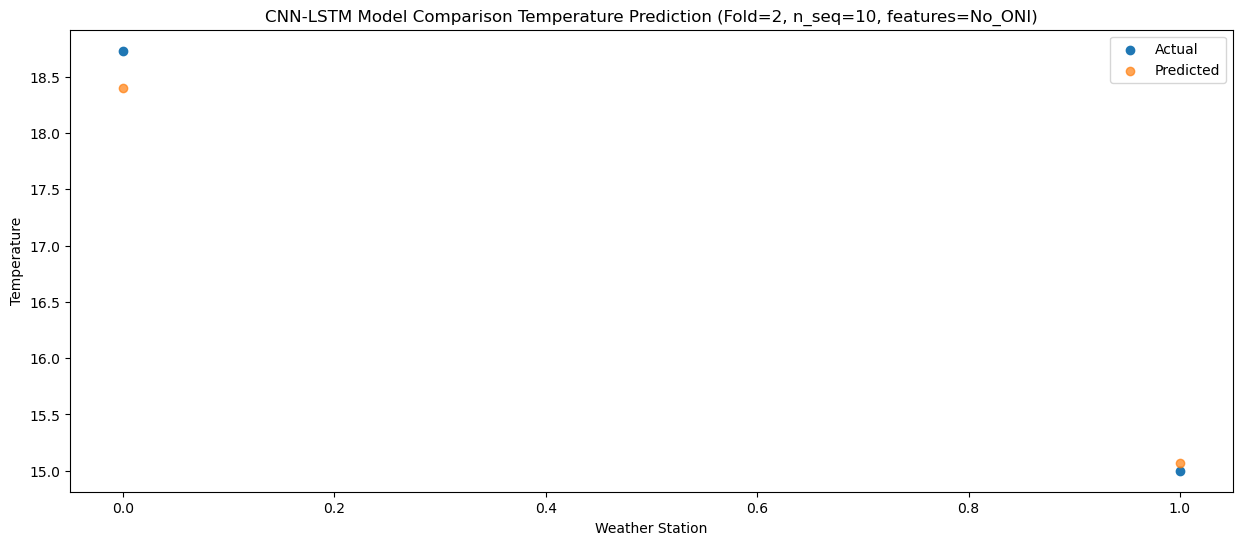

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   18.51  18.051689
1                1   14.82  14.721689


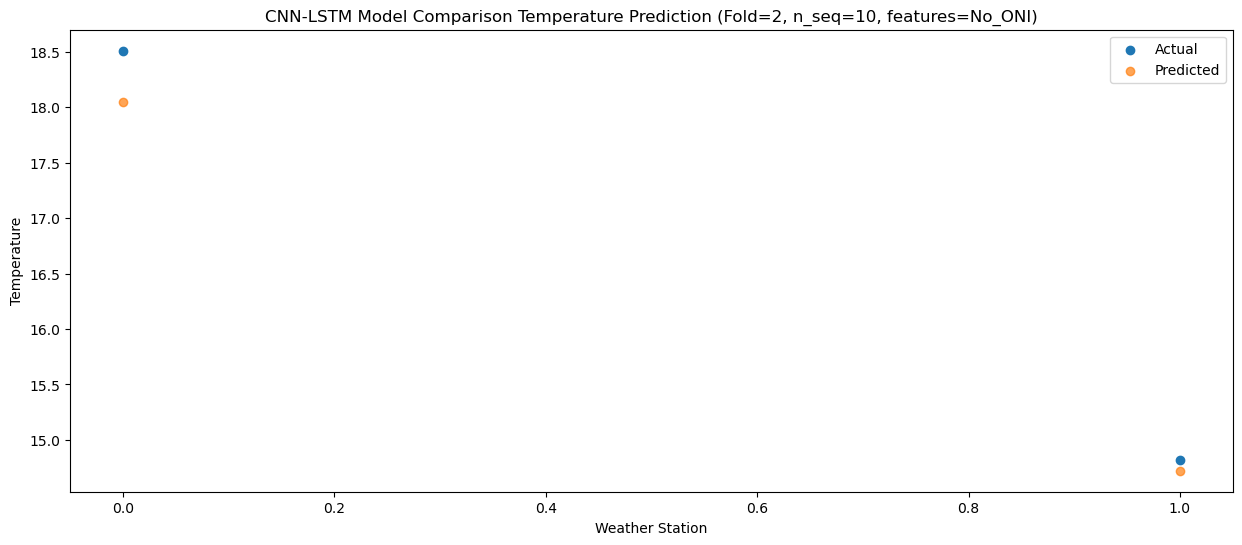

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   17.88   17.51596
1                1   14.35   14.18596


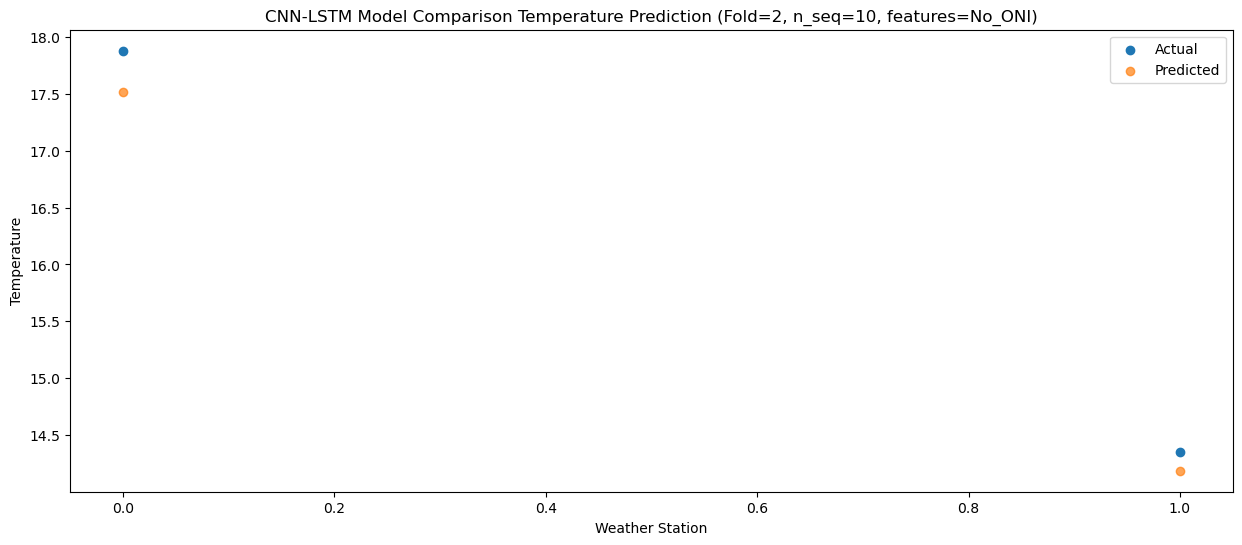

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   18.64  17.206143
1                1   14.68  13.876143


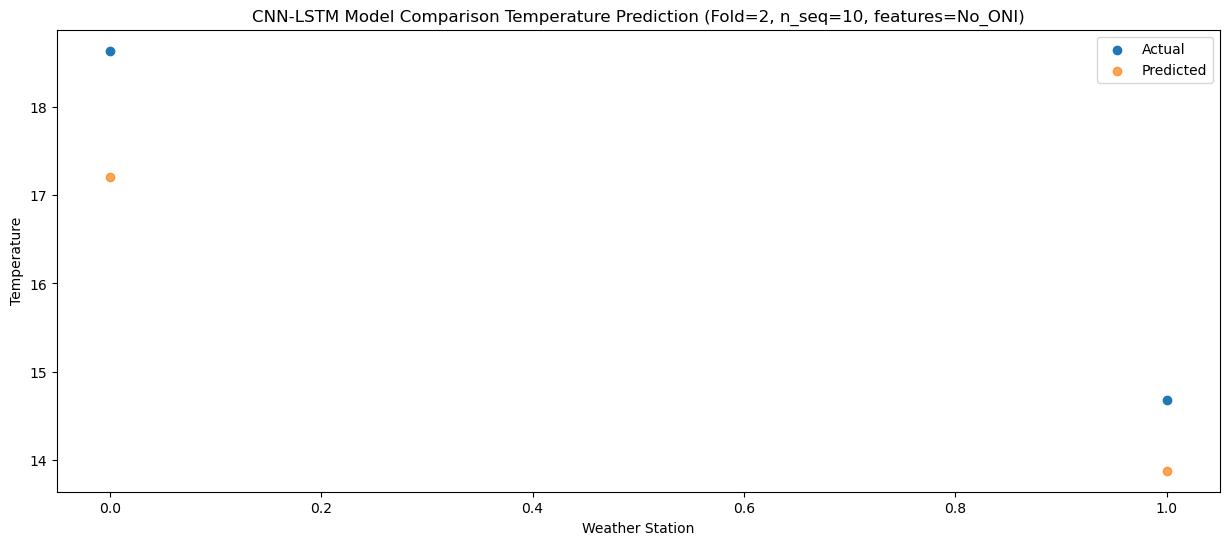

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   17.94  18.099242
1                1   14.67  14.769242


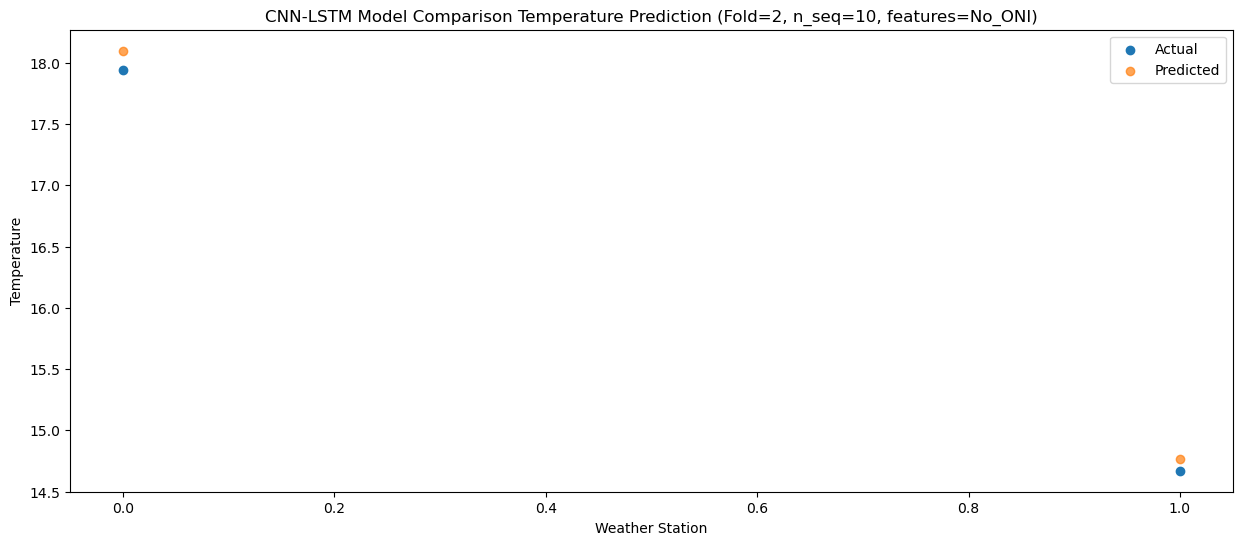

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   18.18  18.249403
1                1   14.66  14.919403


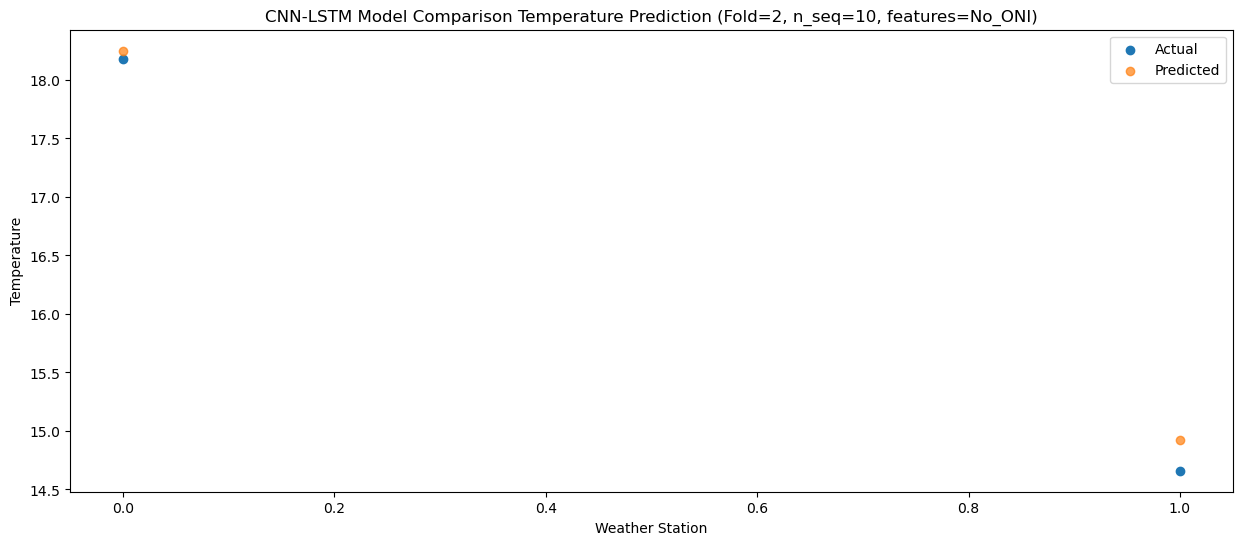

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   18.15  17.713204
1                1   14.20  14.383204


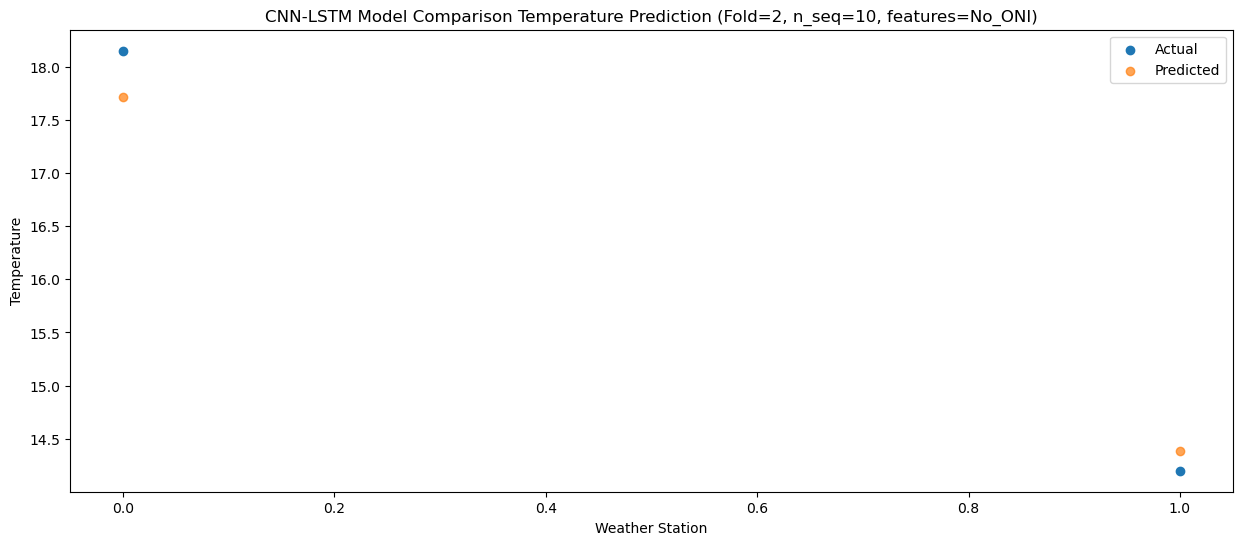

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   18.59   18.69776
1                1   14.99   15.36776


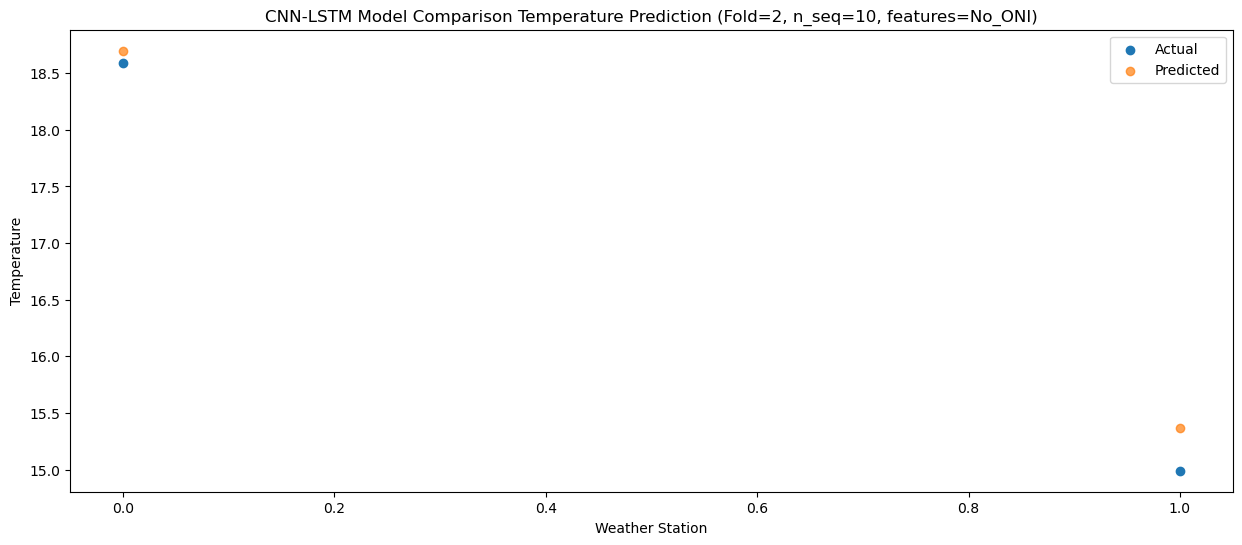

f, t:
[[16.98 12.89]
 [18.17 14.23]
 [18.73 15.  ]
 [18.51 14.82]
 [17.88 14.35]
 [18.64 14.68]
 [17.94 14.67]
 [18.18 14.66]
 [18.15 14.2 ]
 [18.59 14.99]]
[[16.56347531 13.23347531]
 [17.76130324 14.43130324]
 [18.40007043 15.07007043]
 [18.05168888 14.72168888]
 [17.51595983 14.18595983]
 [17.20614317 13.87614317]
 [18.0992417  14.7692417 ]
 [18.24940258 14.91940258]
 [17.71320438 14.38320438]
 [18.69775962 15.36775962]]
Year at t+1:
t+1 SKRMSE: 0.381751
t+1 KRMSE: 0.381751
t+1 MAE: 0.380000
t+1 SKMAPE: 0.025588
t+1 R2_SCORE: 0.965152
t+1 KMAPE: 0.025588
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.322146
t+2 KRMSE: 0.322146
t+2 MAE: 0.305000
t+2 SKMAPE: 0.018320
t+2 R2_SCORE: 0.973259
t+2 KMAPE: 0.018320
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.238499
t+3 KRMSE: 0.238499
t+3 MAE: 0.200000
t+3 SKMAPE: 0.011143
t+3 R2_SCORE: 0.983646
t+3 KMAPE: 0.011143
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.331447
t+4 KRMSE: 0.331447
t+4 MAE: 0.278311
t+4 SKMAPE: 0.015697
t+4 R

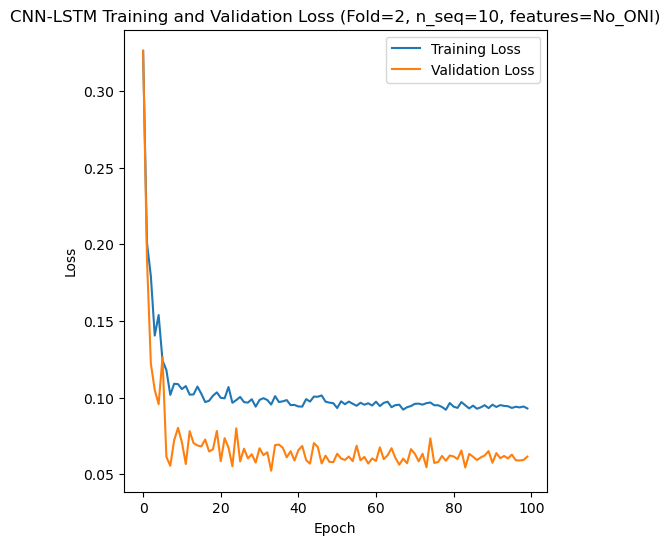

[[14.79 16.53 17.4  17.93 17.46 17.79 17.15 17.27 16.83 16.99 17.41 16.9
  16.66 16.28 17.66 17.63 19.01 18.49 18.19 18.12 18.2  17.83 17.88 18.2
  18.19 17.9  20.04]
 [14.06 13.64 12.62 13.34 13.58 12.56 13.34 13.7  13.71 13.89 12.74 12.51
  12.94 13.34 14.11 12.94 11.91 13.01 14.3  14.13 13.64 14.05 13.93 13.73
  13.43 14.45 16.49]]
Epoch 1/100
20/20 [==============================] - 8s 137ms/step - loss: 0.2903 - accuracy: 0.2000 - mae: 0.2556 - rmse: 0.2903 - mape: 40.1434 - pearson: 0.2159 - val_loss: 0.2192 - val_accuracy: 0.0000e+00 - val_mae: 0.1967 - val_rmse: 0.2192 - val_mape: 34.8355 - val_pearson: 0.3719
Epoch 2/100
20/20 [==============================] - 1s 46ms/step - loss: 0.1530 - accuracy: 0.4000 - mae: 0.1291 - rmse: 0.1530 - mape: 20.7357 - pearson: 0.3351 - val_loss: 0.2182 - val_accuracy: 0.0000e+00 - val_mae: 0.1824 - val_rmse: 0.2182 - val_mape: 26.1019 - val_pearson: 0.0991
Epoch 3/100
20/20 [==============================] - 1s 48ms/step - loss: 0.1580 - acc

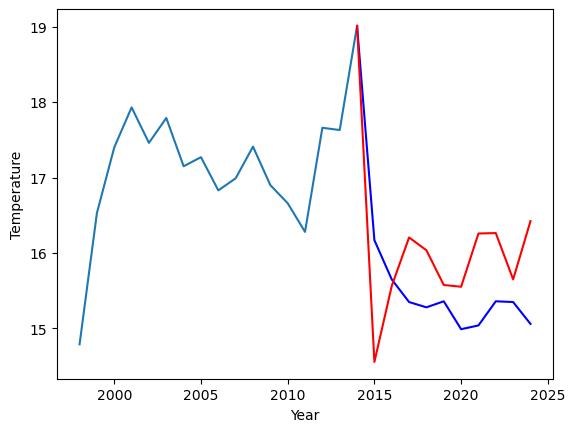

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
13.03		13.83		0.80
14.13		14.83		0.70
15.42		15.48		0.06
15.25		15.31		0.06
14.76		14.85		0.09
15.17		14.82		-0.35
15.05		15.53		0.48
14.85		15.53		0.68
14.55		14.92		0.37
15.57		15.69		0.12


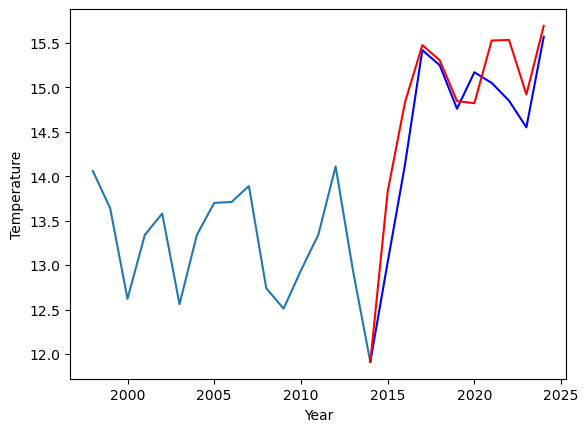

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   16.17  14.556349
1                1   13.03  13.826065


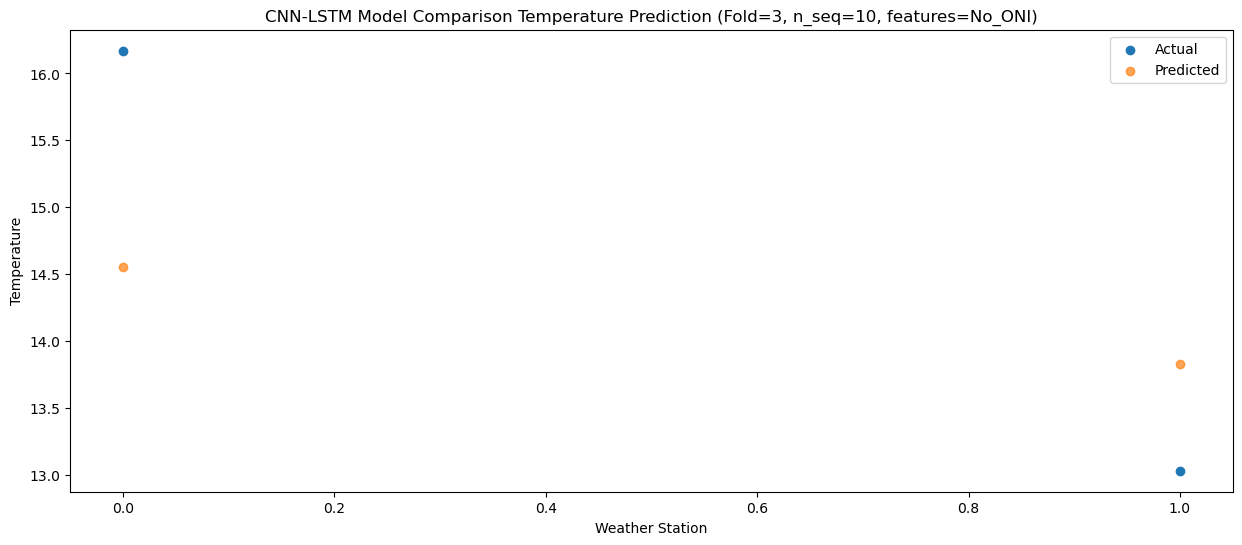

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   15.65  15.562590
1                1   14.13  14.832136


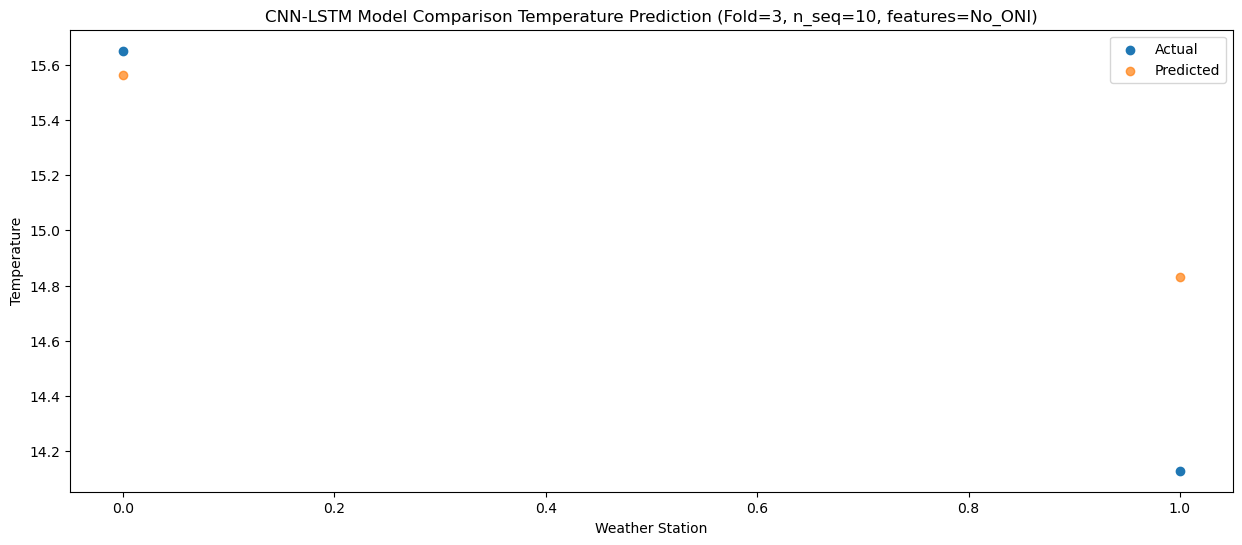

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   15.35  16.206178
1                1   15.42  15.475439


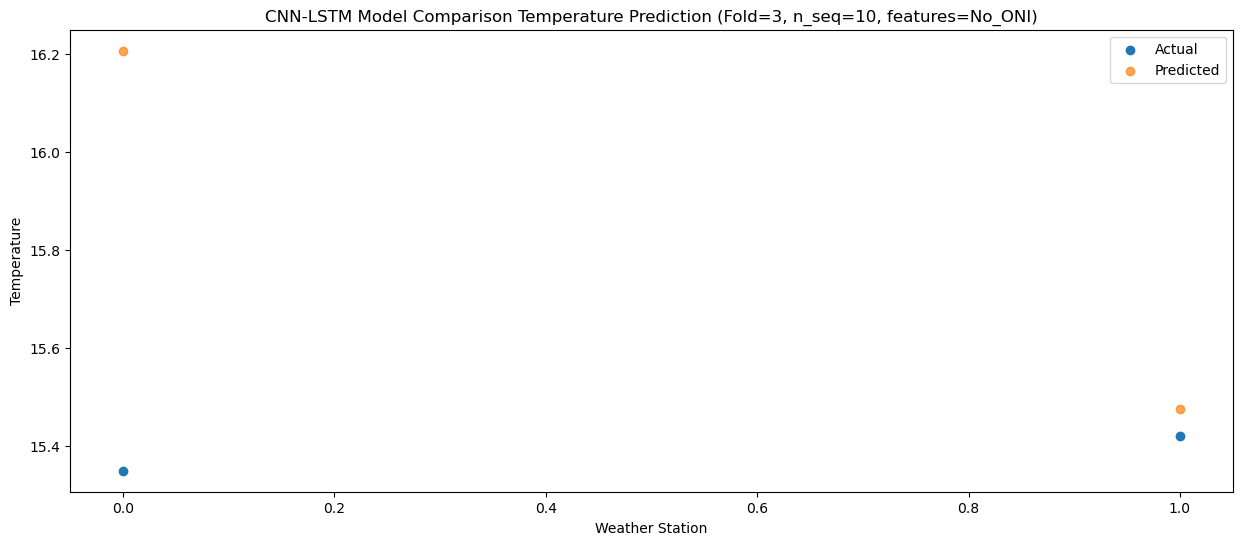

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   15.28  16.036249
1                1   15.25  15.305561


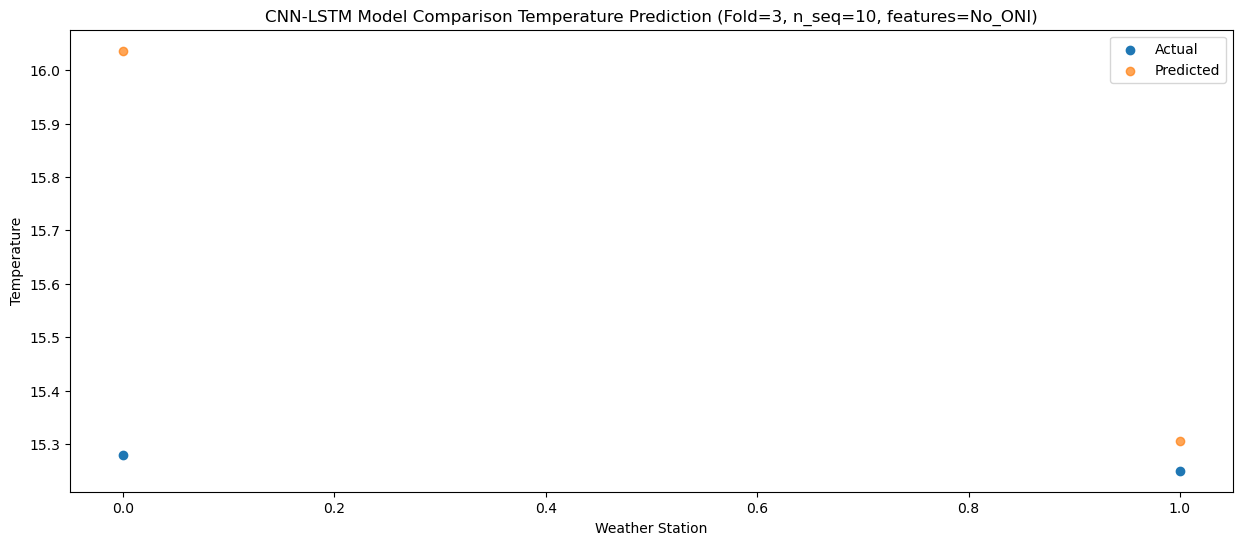

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   15.36  15.576112
1                1   14.76  14.845544


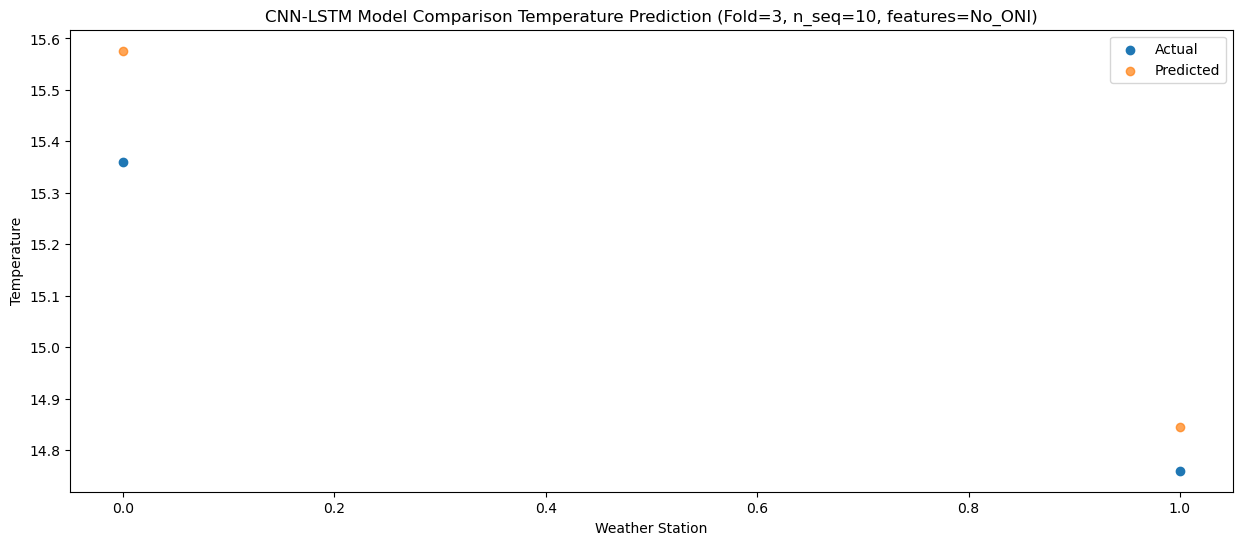

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   14.99  15.552638
1                1   15.17  14.821892


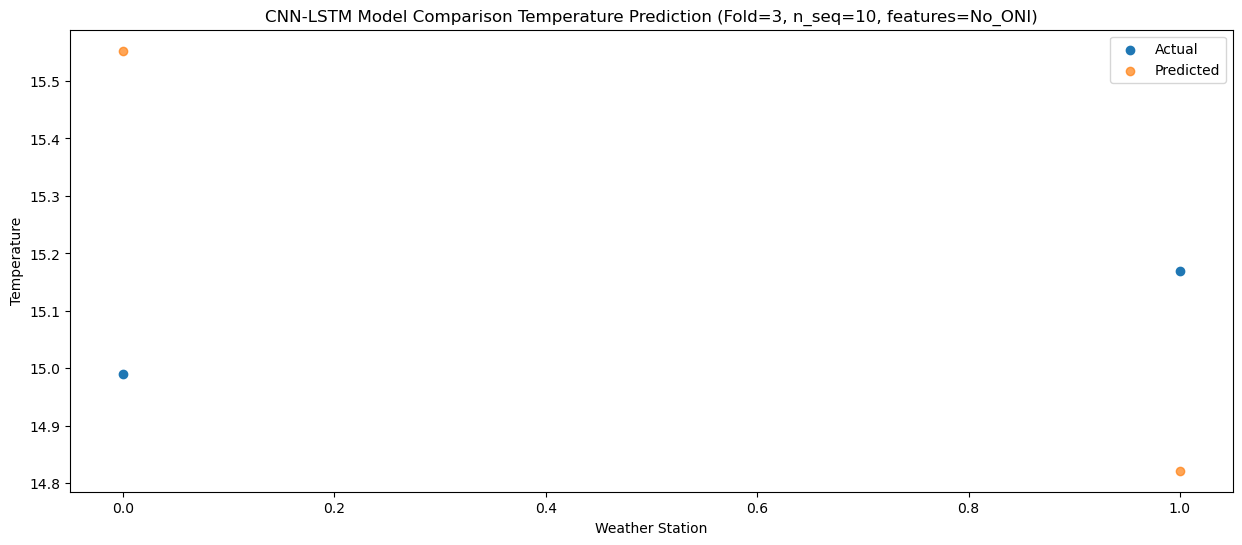

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   15.04  16.258503
1                1   15.05  15.527545


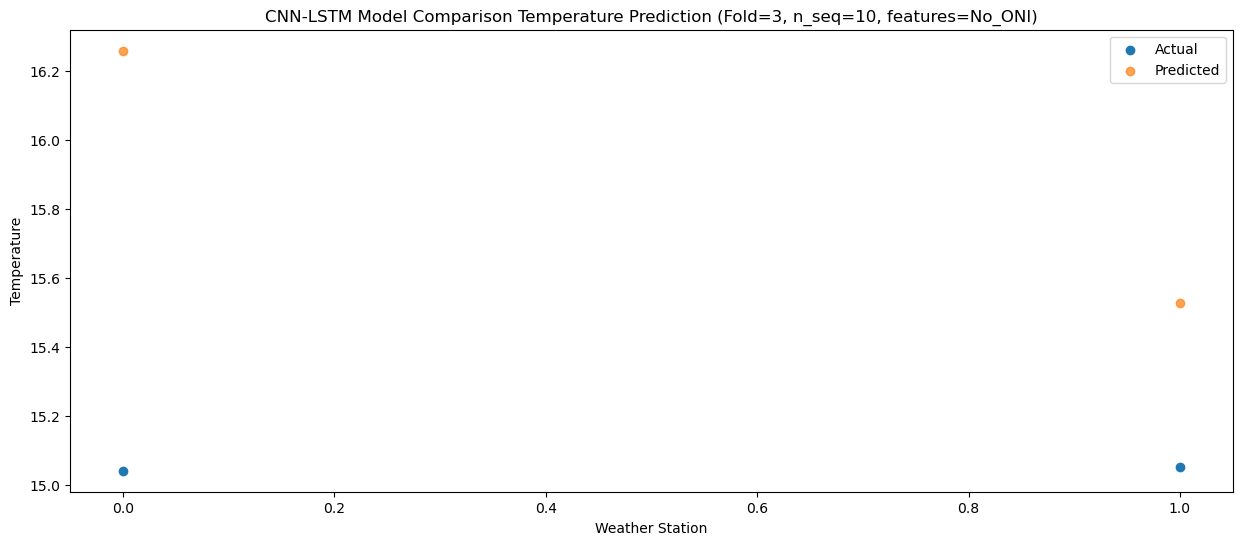

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   15.36  16.264264
1                1   14.85  15.533432


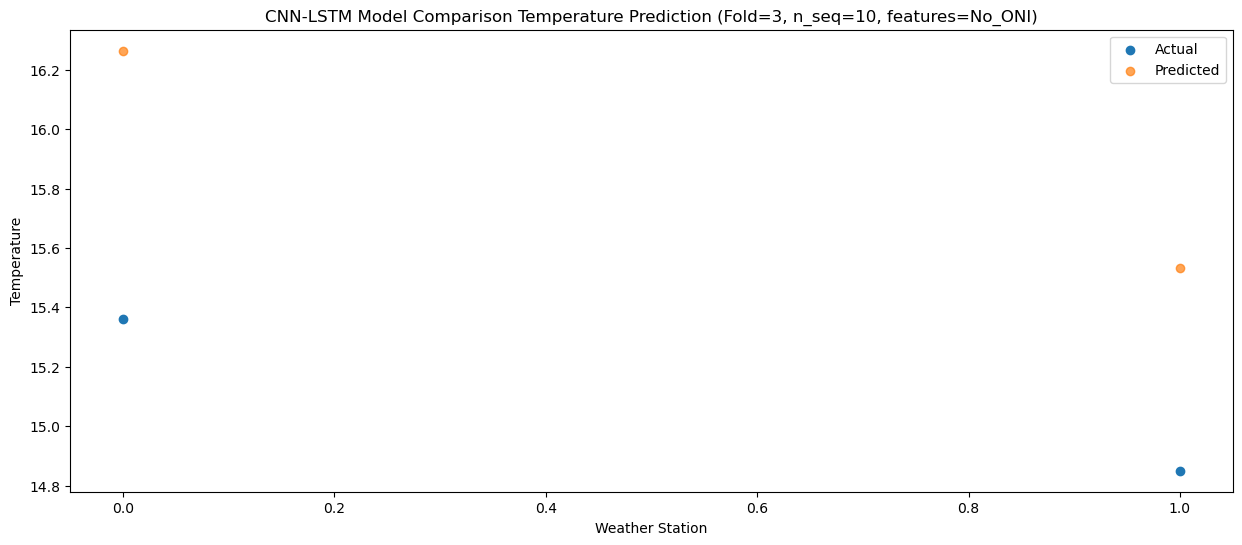

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   15.35  15.650472
1                1   14.55  14.919587


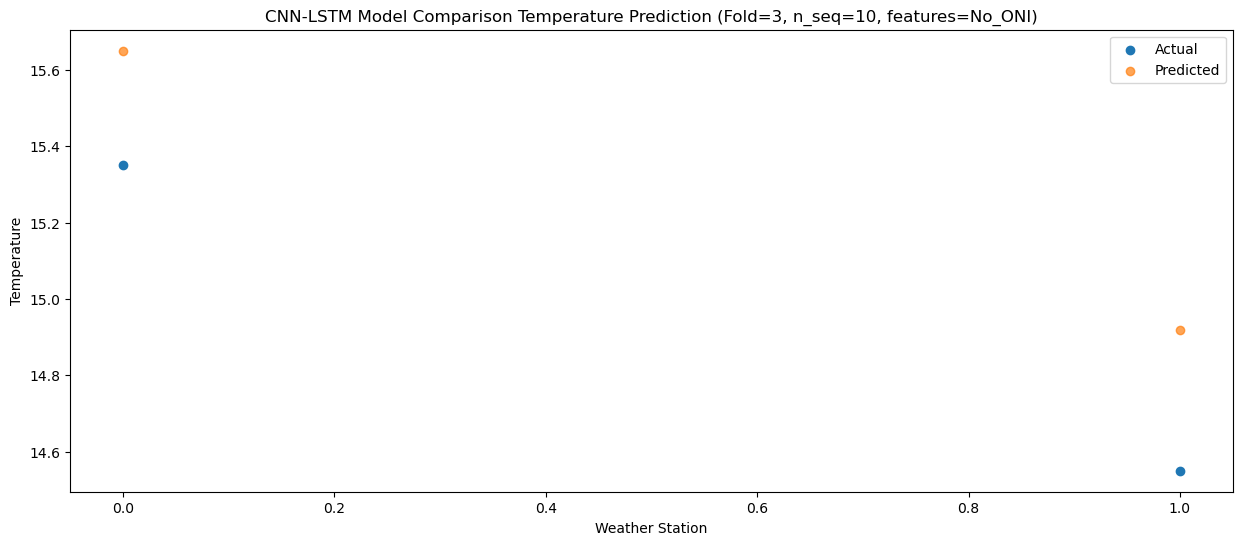

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   15.06  16.422524
1                1   15.57  15.691822


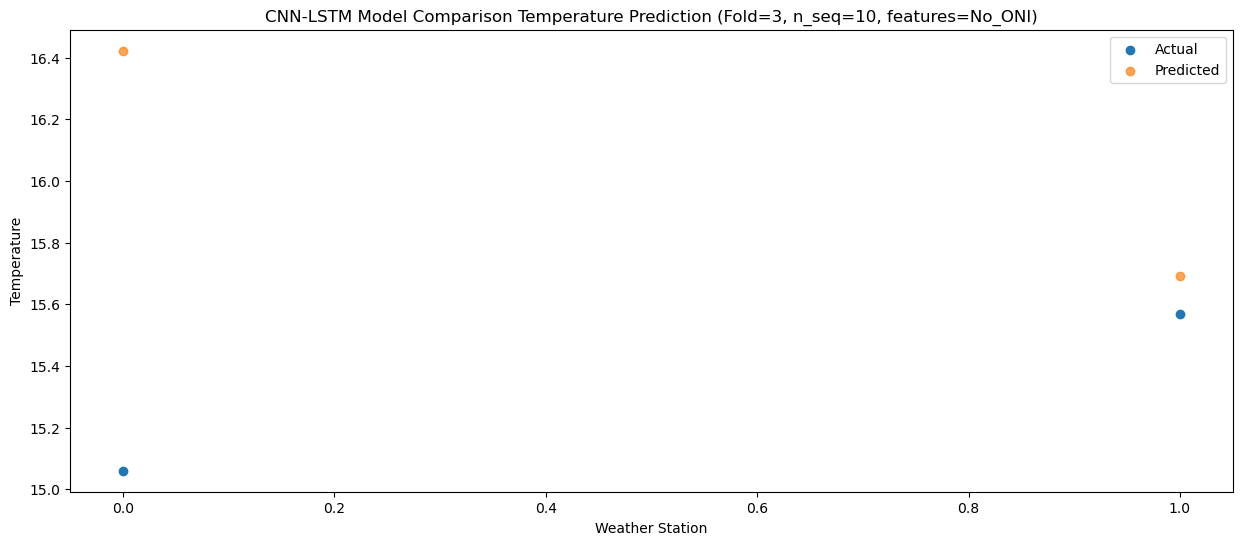

f, t:
[[16.17 13.03]
 [15.65 14.13]
 [15.35 15.42]
 [15.28 15.25]
 [15.36 14.76]
 [14.99 15.17]
 [15.04 15.05]
 [15.36 14.85]
 [15.35 14.55]
 [15.06 15.57]]
[[14.55634912 13.8260654 ]
 [15.56258973 14.83213578]
 [16.20617821 15.47543935]
 [16.0362492  15.3055606 ]
 [15.57611183 14.84554441]
 [15.5526377  14.82189194]
 [16.25850314 15.52754501]
 [16.26426414 15.53343165]
 [15.65047154 14.91958714]
 [16.42252436 15.69182236]]
Year at t+1:
t+1 SKRMSE: 1.272319
t+1 KRMSE: 1.272319
t+1 MAE: 1.204858
t+1 SKMAPE: 0.080444
t+1 R2_SCORE: 0.343262
t+1 KMAPE: 0.080444
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 0.500318
t+2 KRMSE: 0.500318
t+2 MAE: 0.394773
t+2 SKMAPE: 0.027638
t+2 R2_SCORE: 0.566625
t+2 KMAPE: 0.027638
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 0.606677
t+3 KRMSE: 0.606677
t+3 MAE: 0.455809
t+3 SKMAPE: 0.029686
t+3 R2_SCORE: -299.454960
t+3 KMAPE: 0.029686
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 0.536190
t+4 KRMSE: 0.536190
t+4 MAE: 0.405905
t+4 SKMAPE: 0.026568
t+

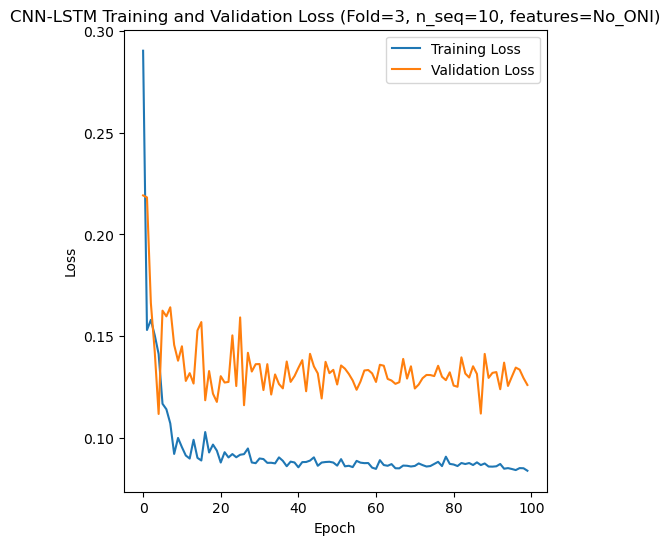

[[21.14 18.96 18.26 17.93 17.59 18.09 18.   18.94 19.77 18.17 18.51 17.84
  17.96 19.05 19.41 17.5  17.5  18.37 18.89 19.09 18.25 18.12 18.64 18.22
  18.72 19.65 20.58]
 [12.93 12.18 11.5  12.1  11.94 11.27 11.81 12.49 12.65 12.57 10.89 11.63
  12.44 12.56 14.1  11.08 10.78 12.73 13.75 13.68 12.38 11.68 12.24 12.56
  11.69 13.17 14.51]]
Epoch 1/100
19/19 [==============================] - 9s 132ms/step - loss: 0.3002 - accuracy: 0.2632 - mae: 0.2730 - rmse: 0.3002 - mape: 43.6893 - pearson: 0.2263 - val_loss: 0.1583 - val_accuracy: 0.0000e+00 - val_mae: 0.1369 - val_rmse: 0.1583 - val_mape: 23.4569 - val_pearson: 0.1780
Epoch 2/100
19/19 [==============================] - 1s 49ms/step - loss: 0.1669 - accuracy: 0.1579 - mae: 0.1388 - rmse: 0.1669 - mape: 22.5430 - pearson: 0.2667 - val_loss: 0.1559 - val_accuracy: 1.0000 - val_mae: 0.1254 - val_rmse: 0.1559 - val_mape: 19.0065 - val_pearson: 0.6417
Epoch 3/100
19/19 [==============================] - 1s 49ms/step - loss: 0.1890 - accur

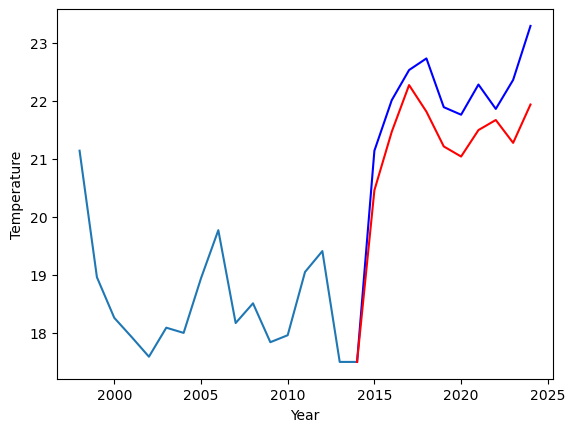

Weather Station 2:
Actual Temp	Predicted Temp	Difference
-----------	--------------	----------
12.63		12.25		-0.38
14.58		13.25		-1.33
15.60		14.06		-1.54
15.53		13.60		-1.93
14.23		13.00		-1.23
13.53		12.83		-0.70
14.09		13.28		-0.81
14.41		13.46		-0.95
13.54		13.06		-0.48
15.02		13.72		-1.30


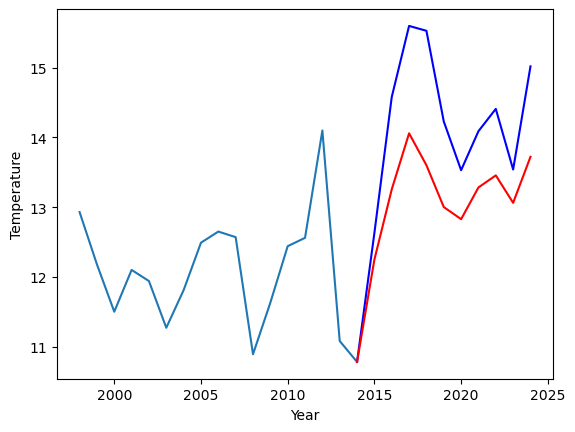

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   21.14  20.458463
1                1   12.63  12.248337


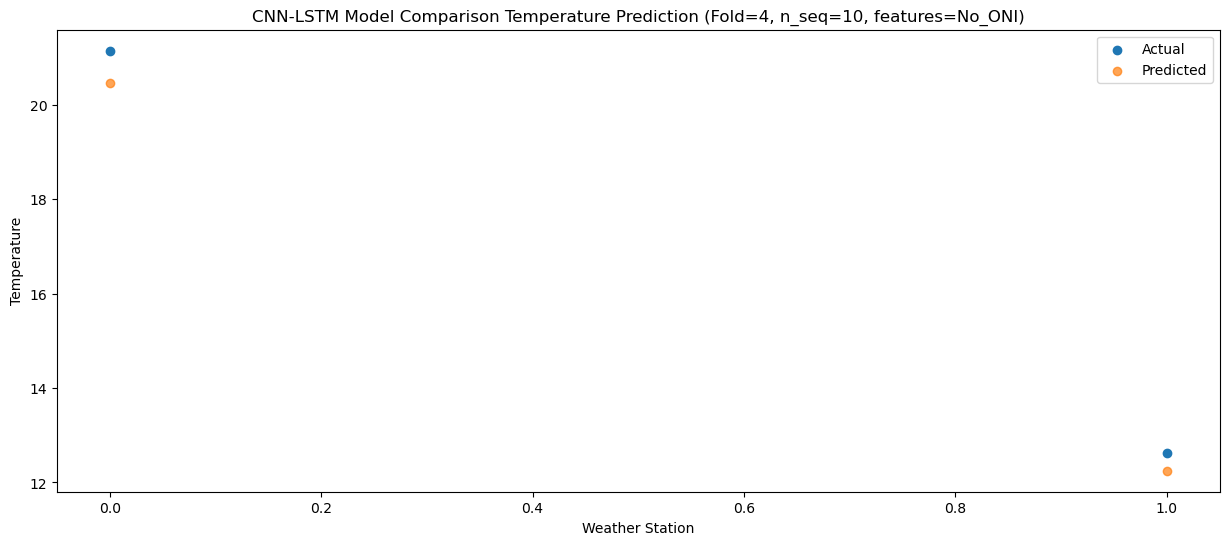

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   22.01  21.465618
1                1   14.58  13.254979


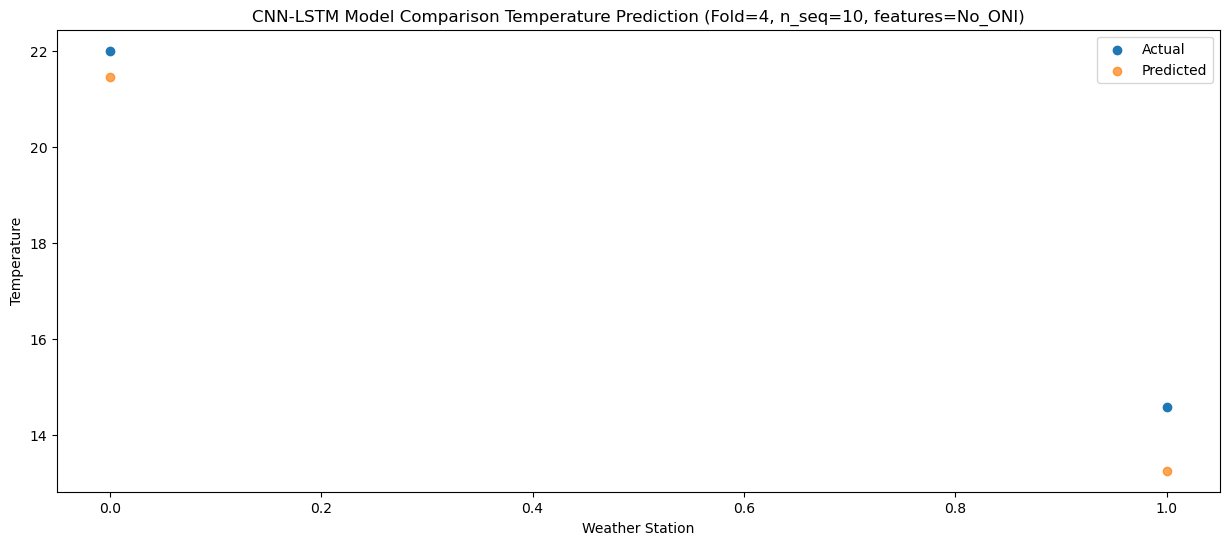

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   22.53  22.270608
1                1   15.60  14.059315


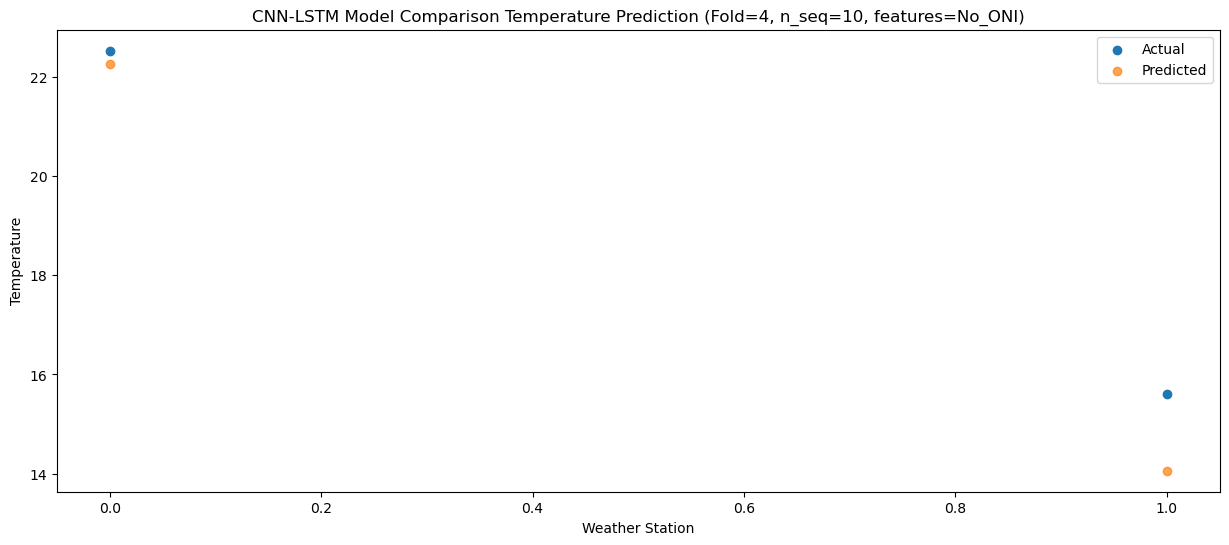

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   22.73  21.812696
1                1   15.53  13.601504


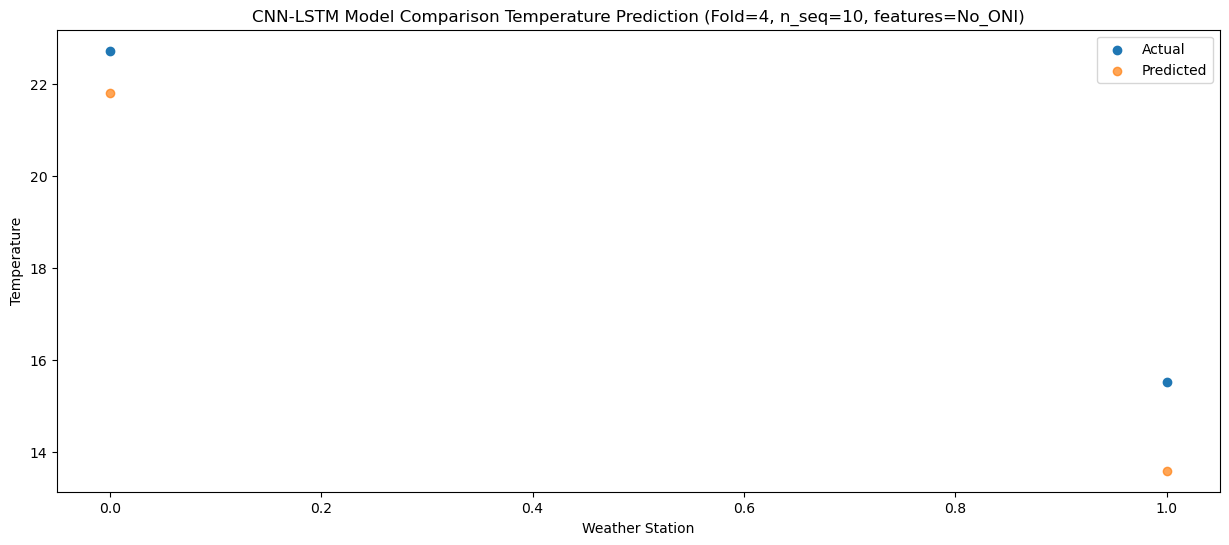

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   21.89  21.213290
1                1   14.23  13.002057


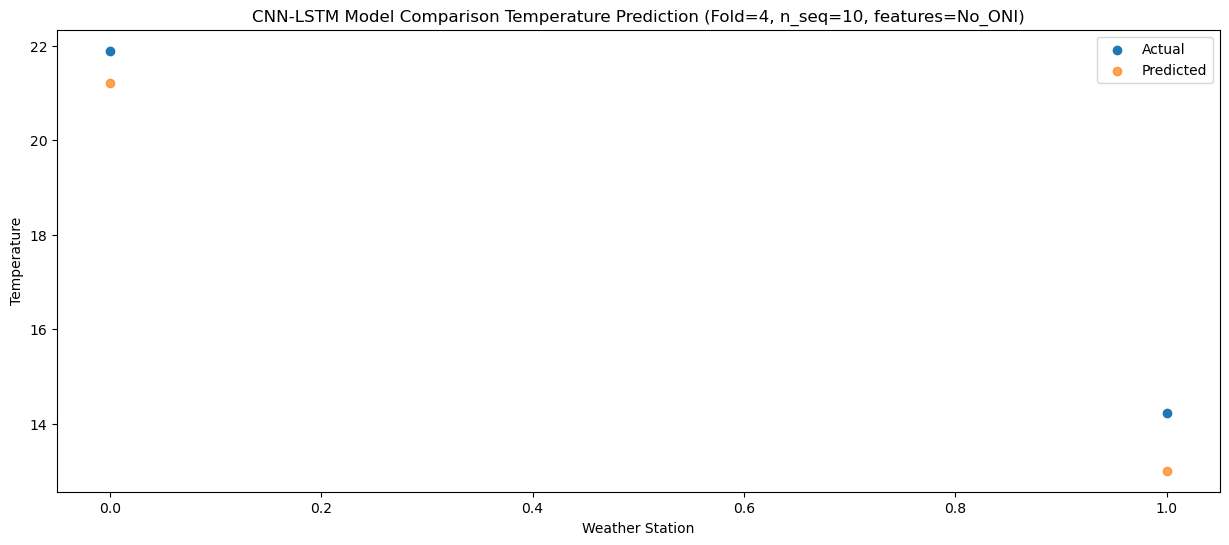

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   21.76  21.039349
1                1   13.53  12.827523


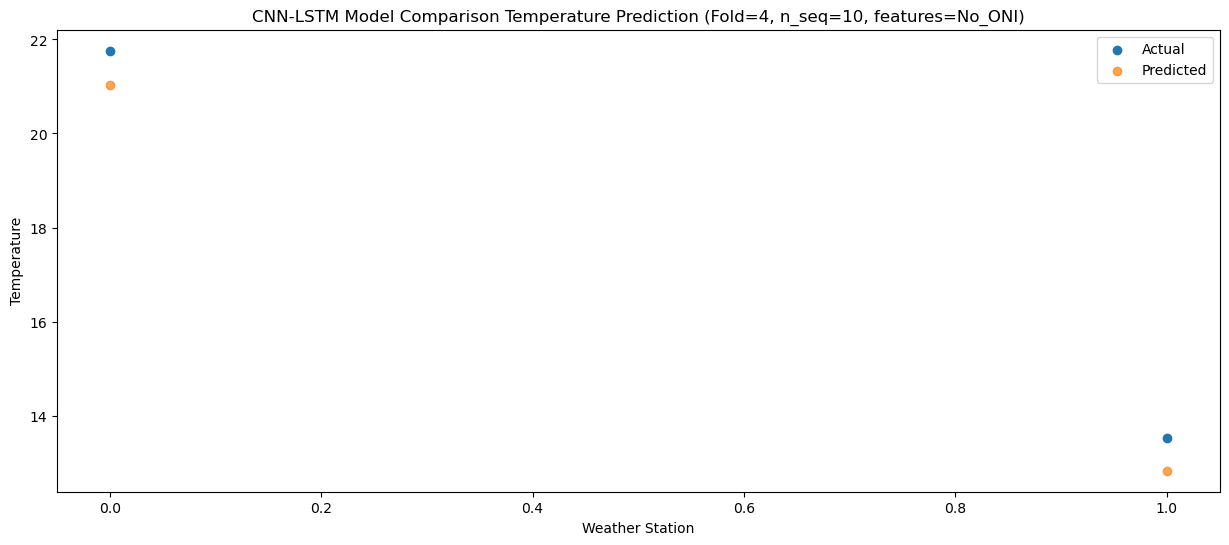

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   22.28  21.495300
1                1   14.09  13.282882


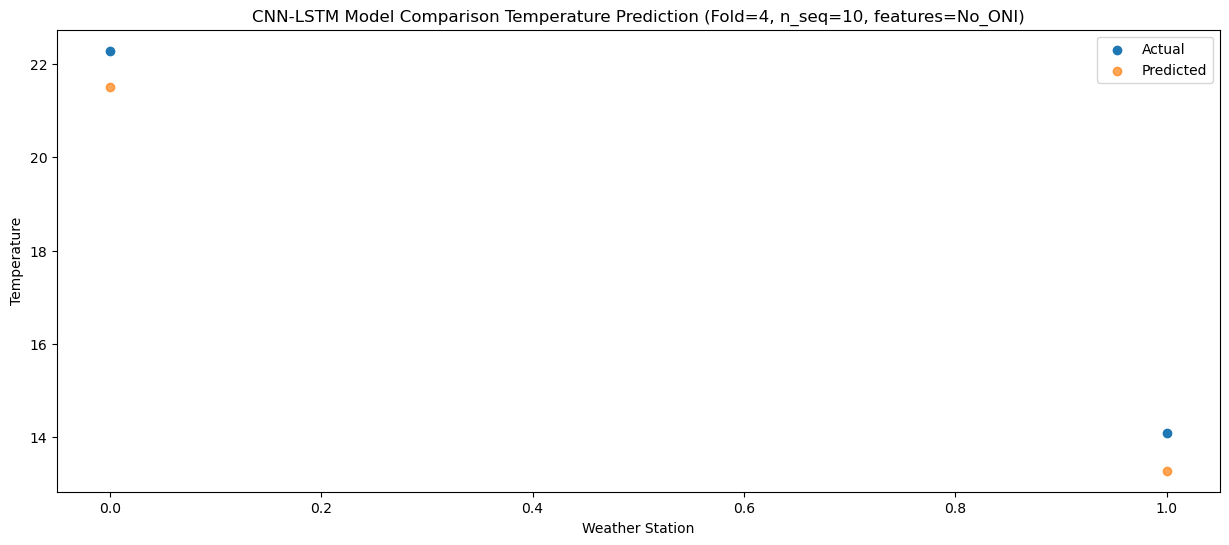

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   21.86  21.668669
1                1   14.41  13.456067


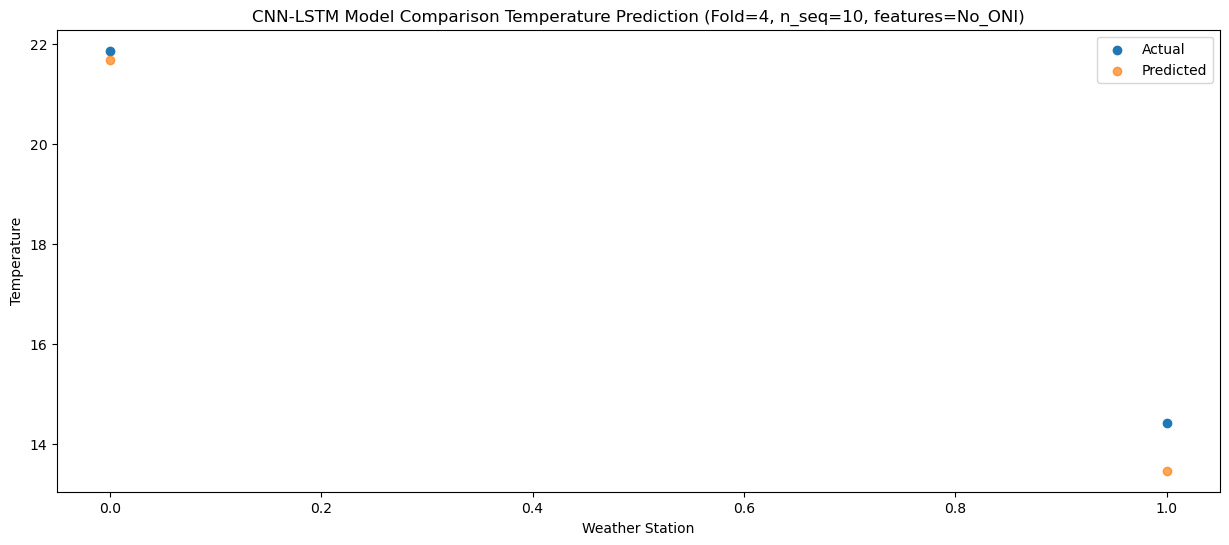

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   22.36  21.274840
1                1   13.54  13.062012


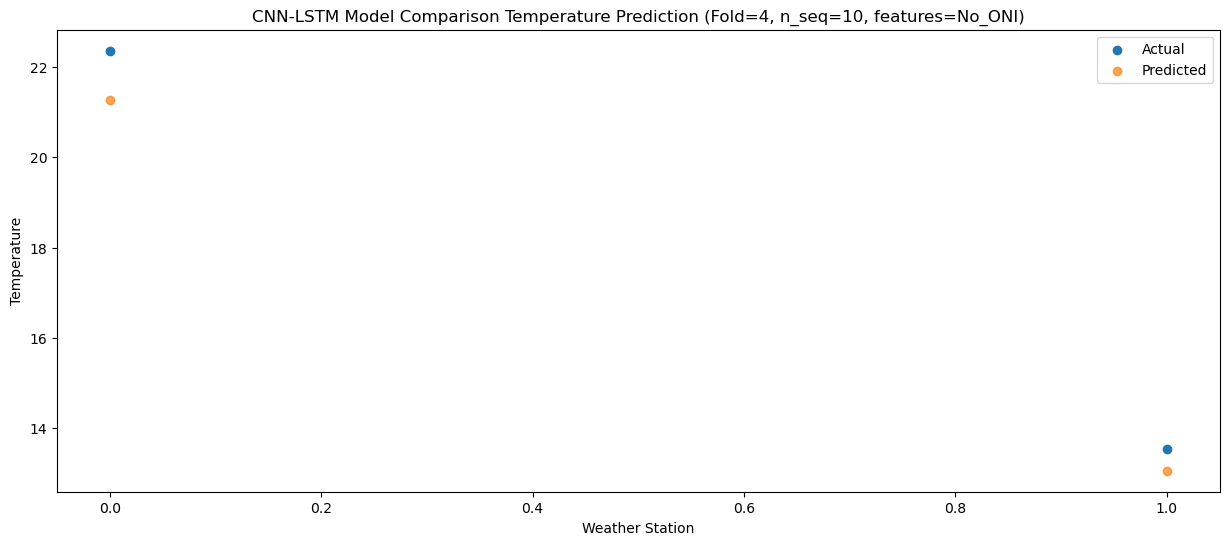

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   23.29  21.935365
1                1   15.02  13.722528


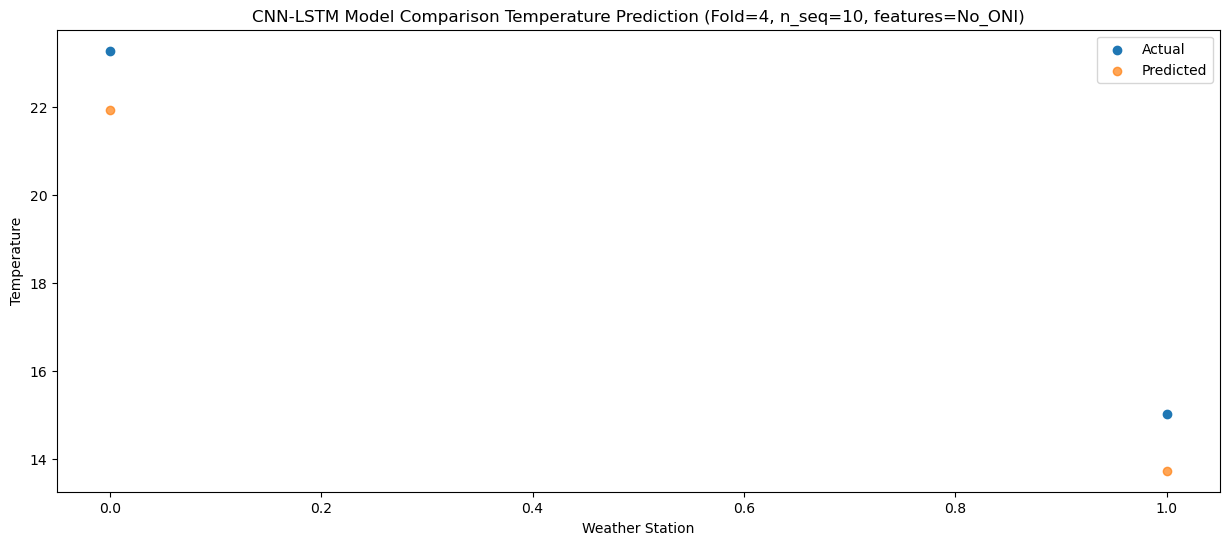

f, t:
[[21.14 12.63]
 [22.01 14.58]
 [22.53 15.6 ]
 [22.73 15.53]
 [21.89 14.23]
 [21.76 13.53]
 [22.28 14.09]
 [21.86 14.41]
 [22.36 13.54]
 [23.29 15.02]]
[[20.45846297 12.24833667]
 [21.46561839 13.25497925]
 [22.27060832 14.0593146 ]
 [21.81269552 13.60150417]
 [21.21329005 13.00205674]
 [21.03934948 12.82752324]
 [21.49529974 13.28288183]
 [21.66866878 13.4560675 ]
 [21.27484024 13.06201192]
 [21.93536496 13.72252782]]
Year at t+1:
t+1 SKRMSE: 0.552340
t+1 KRMSE: 0.552340
t+1 MAE: 0.531600
t+1 SKMAPE: 0.031229
t+1 R2_SCORE: 0.983149
t+1 KMAPE: 0.031229
t+1 PEARSON: 1.000000
Year at t+2:
t+2 SKRMSE: 1.012924
t+2 KRMSE: 1.012924
t+2 MAE: 0.934701
t+2 SKMAPE: 0.057806
t+2 R2_SCORE: 0.925658
t+2 KMAPE: 0.057806
t+2 PEARSON: 1.000000
Year at t+3:
t+3 SKRMSE: 1.104761
t+3 KRMSE: 1.104761
t+3 MAE: 0.900039
t+3 SKMAPE: 0.055138
t+3 R2_SCORE: 0.898345
t+3 KMAPE: 0.055138
t+3 PEARSON: 1.000000
Year at t+4:
t+4 SKRMSE: 1.510057
t+4 KRMSE: 1.510057
t+4 MAE: 1.422900
t+4 SKMAPE: 0.082268
t+4 R

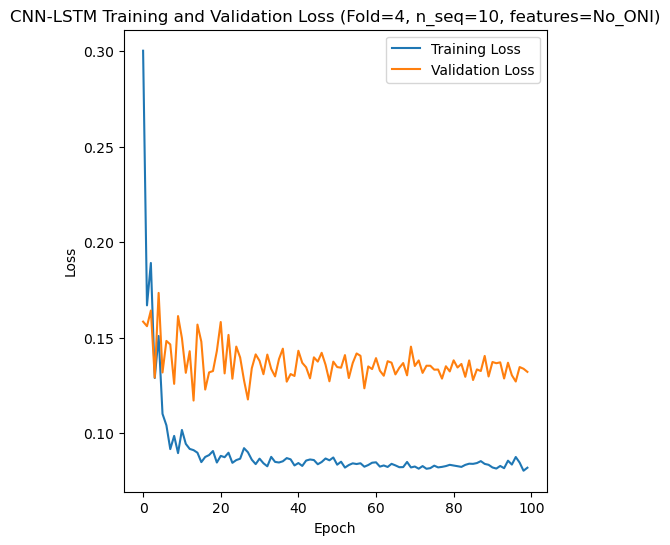

[[0.7073428182608072], [0.7645940215835036], [0.45716787538607284], [0.7292758148489501], [0.9945005155905018]]
[[array(0.70734282)], [array(0.76459402)], [array(0.45716788)], [array(0.72927581)], [array(0.99450052)]]
[[0.5416766408607373], [0.6702744865715508], [0.3392612035274509], [0.5786620522588487], [0.8929298913776874]]
[[0.027384451935181076], [0.032923185585568795], [0.02050444116732273], [0.03849671339360549], [0.05254803591121475]]
[[0.8812304709879086], [-1.5975935671176713], [0.9444883663902497], [-0.36399870516209054], [0.9383004789556296]]
[[array(0.02738445)], [array(0.03292319)], [array(0.02050444)], [array(0.03849671)], [array(0.05254804)]]
[[array(0.91777468)], [array(0.18301562)], [array(0.95510972)], [array(0.2602695)], [array(0.98947206)]]
[20.39 21.69 22.42 22.78 21.56 21.49 21.66 21.49 21.73 22.15 16.37 17.64
 17.8  18.04 18.   18.95 18.12 17.61 17.89 17.72 19.63 20.16 20.45 20.41
 20.24 20.32 20.41 19.49 19.83 20.67 19.88 19.4  20.43 20.81 19.96 20.09
 20.61 20

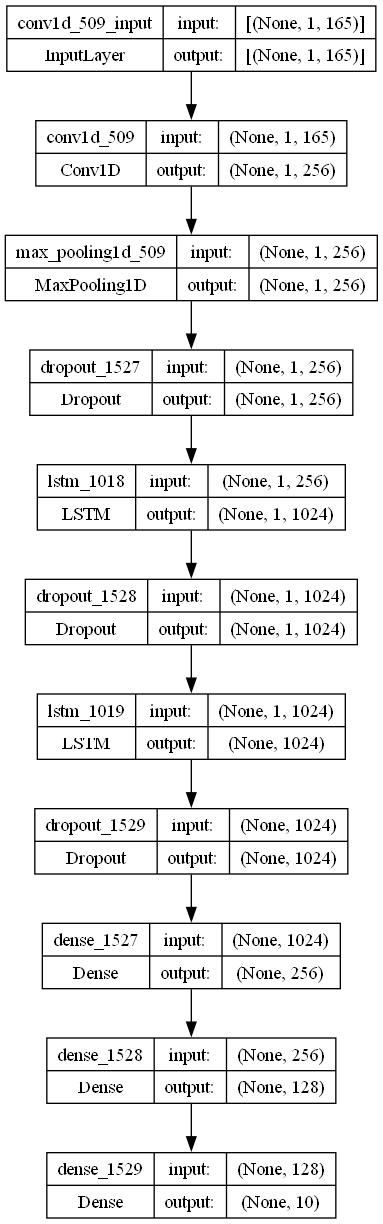

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best CNN-LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    filters = 256
    lr = 0.0017099065957571265
    optimizer = Adam(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 1024
    dropout_rate = 0.30063283093064674

    # design network
    model = Sequential()
    model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(MaxPooling1D(pool_size=1)) # CNN-LSTM only
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# Make one forecast with a CNN-LSTM
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_cnnlstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# Evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_cnnlstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Temperature")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (temperatures)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual Temp\tPredicted Temp\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (temperatures)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='CNN-LSTM Model Comparison Temperature Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Temperature')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)                        
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'CNN-LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_ONI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))

# Plot model architecture
filename = "cnnlstm_model_optimized_CV_S10_No_ONI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)